<a href="https://colab.research.google.com/github/luan3642/3DCarousel/blob/master/TA1_Tarefa_textura.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.4 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

In [ ]:
from medmnist import PneumoniaMNIST
train_dataset = PneumoniaMNIST(split='train', download=True, size=64)

100%|██████████| 20.6M/20.6M [00:02<00:00, 7.39MB/s]


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
normal_images = []
pneumonia_images = []

In [ ]:
dataset = train_dataset

Normal: 10 | Pneumonia: 10


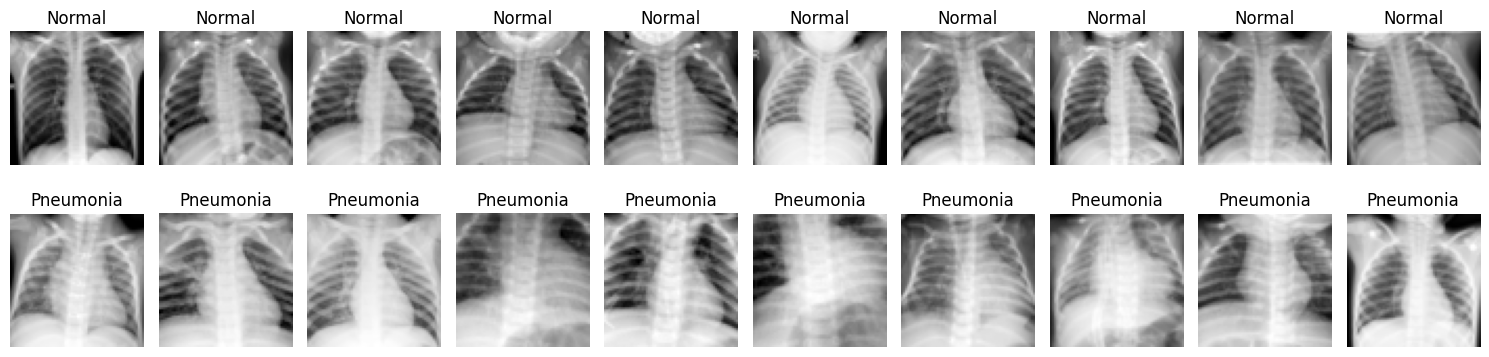

In [ ]:
for i in range(len(dataset)):
    image, label = dataset[i]
    image_np = np.squeeze(np.array(image))

    if label[0] == 0 and len(normal_images) < 10:
        normal_images.append(image_np)
    elif label[0] == 1 and len(pneumonia_images) < 10:
        pneumonia_images.append(image_np)

    if len(normal_images) == 10 and len(pneumonia_images) == 10:
        break

# Ensure both lists have 10 items
print("Normal:", len(normal_images), "| Pneumonia:", len(pneumonia_images))

# Plot
fig, axes = plt.subplots(2, 10, figsize=(15, 4))

for i in range(10):
    axes[0, i].imshow(normal_images[i], cmap='gray')
    axes[0, i].set_title("Normal")
    axes[0, i].axis('off')

    axes[1, i].imshow(pneumonia_images[i], cmap='gray')
    axes[1, i].set_title("Pneumonia")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
images = normal_images +pneumonia_images

In [ ]:
def build_gabor_kernels(scales, orientations, ksize=5):
    kernels = []
    for sigma in scales:
        for theta in orientations:
            lam = sigma
            gamma = 0.5
            psi = 0
            kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lam, gamma, psi, ktype=cv2.CV_32F)
            kern /= np.linalg.norm(kern)
            kernels.append(kern)
    return kernels

def apply_filter_bank(img, kernels):
    responses = []
    for kern in kernels:
        f = cv2.filter2D(img, cv2.CV_32F, kern)
        responses.append(np.abs(f))
    return np.stack(responses, axis=-1)

def extract_patch_features(energy_stack, patch_size):
    h, w, D = energy_stack.shape
    ph, pw = patch_size
    n_patches_y = h // ph
    n_patches_x = w // pw

    # Check if there are enough patches
    if n_patches_y * n_patches_x < N_CLUSTERS:  # Ensure enough patches for clustering
        # Handle cases with insufficient patches:
        # Option 1: Reduce patch size
        # Option 2: Reduce number of clusters
        # Option 3: Return early or raise an error
        ph = ph // 2
        pw = pw // 2
        n_patches_y = h // ph
        n_patches_x = w // pw

    feats = []
    for i in range(n_patches_y):
        for j in range(n_patches_x):
            patch = energy_stack[i*ph:(i+1)*ph, j*pw:(j+1)*pw]
            feats.append(patch.reshape(-1, D).mean(axis=0))
    return np.vstack(feats), (n_patches_y, n_patches_x)

def texture_segmentation(img,
                         n_clusters=4,
                         scales=[4, 8, 16],
                         orientations=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                         patch_size=(16,16)):
    kernels = build_gabor_kernels(scales, orientations)
    energy = apply_filter_bank(img, kernels)
    feats, (ny, nx) = extract_patch_features(energy, patch_size)
    km = KMeans(n_clusters=n_clusters, random_state=0).fit(feats)
    labels = km.labels_.reshape(ny, nx)
    vis = cv2.resize(labels.astype(np.float32), (img.shape[1], img.shape[0]),
                     interpolation=cv2.INTER_NEAREST)
    cmap = plt.get_cmap('tab10', n_clusters)
    color_seg = cmap(vis.astype(int)/(n_clusters-1))[..., :3]
    return labels, (color_seg*255).astype(np.uint8)

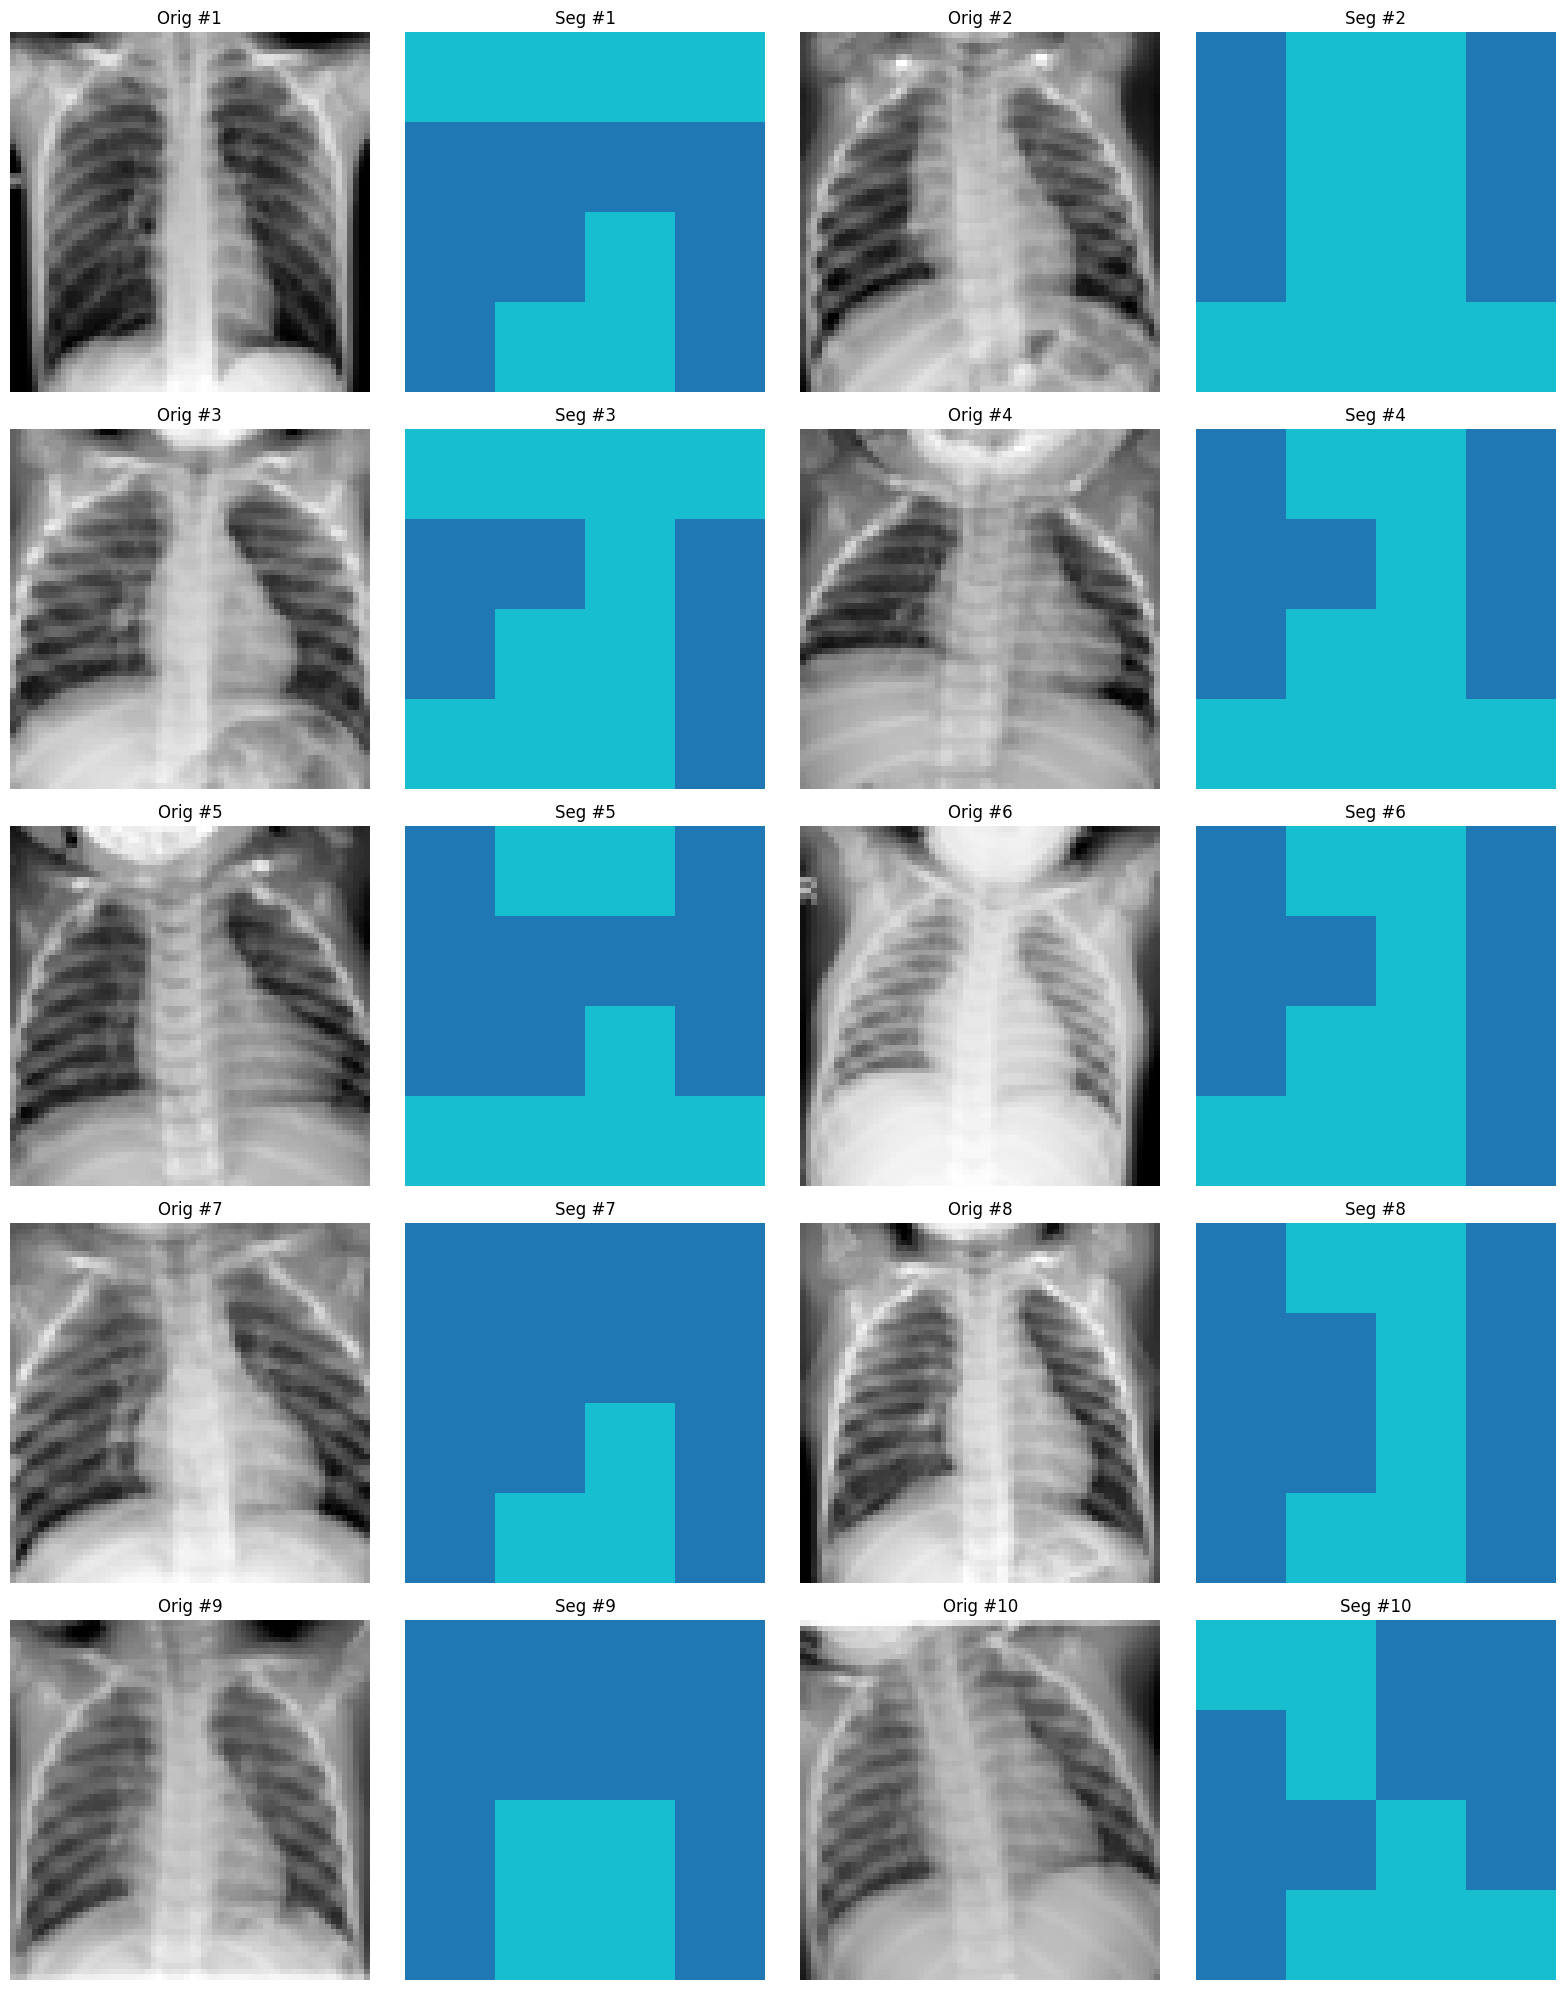

In [ ]:
# Parameters you can tweak
N_CLUSTERS   = 2
SCALES       = [4, 8, 16]
ORIENTATIONS = [0, np.pi/4, np.pi/2, 3*np.pi/4]
PATCH_SIZE   = (16, 16)

# Prepare a matplotlib grid
n = len(images)
cols = 4
rows = (n + cols - 1) // cols

num_plots = n * 2  # 2 plots per image (original and segmented)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows)) # Create subplots with fig and axes

# Flatten the axes array for easier indexing
axes = axes.flatten()

for idx, img in enumerate(images):  # Use enumerate to get both index and image
    # Ensure single-channel float image
    gray = img.astype(np.uint8)
    labels, seg = texture_segmentation(
        gray,
        n_clusters=N_CLUSTERS,
        scales=SCALES,
        orientations=ORIENTATIONS,
        patch_size=PATCH_SIZE
    )

    # Calculate correct indices for the current image's plots
    current_index = idx * 2

    # Check if current_index is within bounds
    if current_index < len(axes):
        # show
        axes[current_index].imshow(gray, cmap='gray')
        axes[current_index].set_title(f"Orig #{idx+1}")
        axes[current_index].axis('off')

    # Calculate index for the segmented image plot
    seg_index = current_index + 1

    # Check if seg_index is within bounds
    if seg_index < len(axes):
        axes[seg_index].imshow(seg)
        axes[seg_index].set_title(f"Seg #{idx+1}")
        axes[seg_index].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
#teste

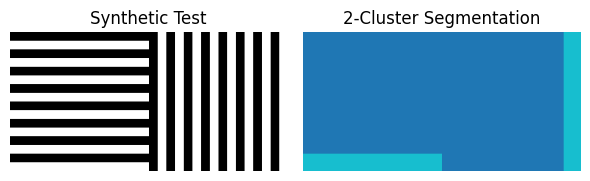

In [ ]:
# 1) Build a test image: left=horizontal stripes, right=vertical stripes
h, w = 128, 256
img = np.zeros((h, w), dtype=np.uint8)
# horizontal stripes on left
img[:, :w//2] = ((np.arange(h) // 8) % 2)[:, None] * 255
# vertical stripes on right
img[:, w//2:] = ((np.arange(w//2) // 8) % 2)[None, :] * 255

# 2) Run your texture_segmentation (with 2 clusters)
labels, seg = texture_segmentation(img,
                                   n_clusters=2,
                                   scales=[4,16],
                                   orientations=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                                   patch_size=(16,16))

# 3) Show original + segmentation side by side
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.title("Synthetic Test")
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.title("2‑Cluster Segmentation")
plt.axis('off')
plt.imshow(seg)
plt.tight_layout()
plt.show()


In [ ]:
# Definir o tamanho da janela para extração de características
WINDOW_SIZE = 16
# Definir o número de clusters para segmentação
N_CLUSTERS = 2

# Carregar o dataset PneumoniaMNIST
def load_dataset(default_amout=10):
    data_train = PneumoniaMNIST(split='train', download=True, size=64)
    data_test = PneumoniaMNIST(split='test', download=True, size=64)

    # Pegar algumas imagens para teste com seus rótulos
    images = data_test.imgs[:default_amout]  # Pegando 10 imagens de teste
    labels = data_test.labels[:default_amout].squeeze()  # 0: normal, 1: pneumonia

    return images, labels

# Criar filtros de Gabor em diferentes orientações e escalas
def create_gabor_filters():
    filters = []
    ksize = 31

    # Definir diferentes orientações (em graus)
    thetas = [0, 45, 90, 135]  # 0° (horizontal), 45°, 90° (vertical), 135°

    # Definir diferentes escalas (lambdas)
    lambdas = [3, 6, 12]  # Três escalas diferentes

    # Criar filtros de Gabor para cada combinação de orientação e escala
    for theta in thetas:
        for lambd in lambdas:
            # Converter graus para radianos
            theta_rad = theta * np.pi / 180

            # Criar filtro de Gabor
            kern = cv2.getGaborKernel(
                (ksize, ksize),
                sigma=lambd/3,
                theta=theta_rad,
                lambd=lambd,
                gamma=0.5,
                psi=0,
                ktype=cv2.CV_32F
            )

            # Normalizar o kernel
            kern /= 1.5*kern.sum()

            # Adicionar à lista de filtros
            filters.append((kern, f"{theta}°_lambda{lambd}"))


    # Criar filtro circular (LoG - Laplacian of Gaussian)
    for sigma in [1, 2, 4]:  # Três escalas para o filtro circular
        size = int(ksize / 2)
        x = np.arange(-size, size + 1)

        # Criar filtro gaussiano 1D
        gaussian_1d = np.exp(-(x**2) / (2.0 * sigma**2))
        gaussian_1d = gaussian_1d / np.sum(gaussian_1d)  # Normalizar

        # Criar filtro LoG 1D
        log_1d = -(x**2 / sigma**4 - 1 / sigma**2) * gaussian_1d
        log_1d = log_1d - np.mean(log_1d)  # Garantir que a soma seja zero

        # Criar filtros 2D separáveis
        kernel_h = log_1d.reshape(1, -1)  # Filtro horizontal
        kernel_v = log_1d.reshape(-1, 1)  # Filtro vertical

        filters.append((kernel_h, f"circular_sigma{sigma}_h"))
        filters.append((kernel_v, f"circular_sigma{sigma}_v"))

    return filters

# Processar uma imagem com filtros de Gabor
def apply_gabor_filters(image, filters):
    # Garantir que a imagem seja float32 para evitar overflow
    image = image.astype(np.float32)

    results = []

    # Aplicar cada filtro na imagem
    for kernel, name in filters:
        # Aplicar convolução
        filtered = cv2.filter2D(image, cv2.CV_32F, kernel)

        # Tomar o valor absoluto da resposta para detectar bordas em qualquer direção
        filtered = np.abs(filtered)

        # Normalizar para visualização
        filtered = cv2.normalize(filtered, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        results.append((filtered, name))

    return results

# Extrair características de textura de uma imagem usando filtros
def extract_texture_features(image, filters):
    # Aplicar filtros
    filtered_images = apply_gabor_filters(image, filters)

    # Determinar a quantidade de janelas em cada dimensão
    h, w = image.shape
    windows_h = h // WINDOW_SIZE
    windows_w = w // WINDOW_SIZE

    # Inicializar matriz de características
    # Cada janela terá um vetor de características (média de cada filtro)
    features = np.zeros((windows_h, windows_w, len(filters)))

    # Para cada janela, calcular características
    for i in range(windows_h):
        for j in range(windows_w):
            # Definir coordenadas da janela
            y_start = i * WINDOW_SIZE
            y_end = (i + 1) * WINDOW_SIZE
            x_start = j * WINDOW_SIZE
            x_end = (j + 1) * WINDOW_SIZE

            # Para cada filtro, calcular a média da resposta na janela
            for k, (filtered_img, _) in enumerate(filtered_images):
                window = filtered_img[y_start:y_end, x_start:x_end]
                features[i, j, k] = np.mean(window)

    return features, filtered_images

# Agrupar regiões com base nas características de textura
def cluster_regions(features, n_clusters=N_CLUSTERS):
    # Verificar se temos exemplos suficientes para o número desejado de clusters
    h, w, n_features = features.shape
    n_samples = h * w

    # Se não tivermos exemplos suficientes, reduzir o número de clusters
    actual_n_clusters = min(n_clusters, n_samples)
    if actual_n_clusters < n_clusters:
        print(f"Aviso: Reduzindo número de clusters de {n_clusters} para {actual_n_clusters} devido ao número limitado de amostras.")

    # Remodelar o array para matriz 2D onde cada linha é um vetor de características
    features_flat = features.reshape(n_samples, n_features)

    # Padronizar as características
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features_flat)

    # Aplicar K-means
    kmeans = KMeans(n_clusters=actual_n_clusters, random_state=42)
    labels = kmeans.fit_predict(features_scaled)

    # Remodelar os rótulos de volta para a forma da imagem
    segmented = labels.reshape(h, w)

    # Obter os centróides dos clusters (características médias de cada grupo)
    centroids = kmeans.cluster_centers_

    return segmented, centroids, kmeans, actual_n_clusters

# Visualizar resultados
def visualize_results(image, filtered_images, segmented, true_label):
    plt.figure(figsize=(20, 12))

    # Plotar imagem original
    plt.subplot(2, 4, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Imagem Original (Label: {"Pneumonia" if true_label == 1 else "Normal"})')
    plt.axis('off')

    # Plotar algumas respostas de filtros (selecionando 3)
    filter_indices = [0, len(filtered_images)//2, len(filtered_images)-1]
    for i, idx in enumerate(filter_indices):
        plt.subplot(2, 4, i+2)
        filtered_img, name = filtered_images[idx]
        plt.imshow(filtered_img, cmap='jet')
        plt.title(f'Filtro: {name}')
        plt.axis('off')

    # Plotar segmentação
    plt.subplot(2, 4, 5)
    plt.imshow(segmented, cmap='nipy_spectral')
    plt.title('Segmentação por Textura')
    plt.axis('off')

    # Contornos na imagem original
    plt.subplot(2, 4, 6)
    # Expandir a imagem segmentada para o tamanho da original
    h, w = image.shape
    segmented_full = np.kron(segmented, np.ones((WINDOW_SIZE, WINDOW_SIZE), dtype=np.uint8))
    segmented_full = segmented_full[:h, :w]  # Recortar para o tamanho exato

    plt.imshow(image, cmap='gray')
    plt.imshow(segmented_full, cmap='nipy_spectral', alpha=0.5)
    plt.title('Segmentação Sobreposta')
    plt.axis('off')

    # Histograma de distribuição dos clusters
    plt.subplot(2, 4, 7)
    unique, counts = np.unique(segmented, return_counts=True)
    plt.bar(unique, counts)
    plt.title('Distribuição dos Clusters')
    plt.xlabel('Cluster ID')
    plt.ylabel('Número de regiões')

    plt.tight_layout()
    plt.show()

# Analisar correlação entre clusters e diagnóstico
def analyze_cluster_patterns(images, labels, n_clusters=N_CLUSTERS):
    # Criar filtros
    filters = create_gabor_filters()

    # Armazenar distribuições de clusters para casos normais e pneumonia
    normal_distributions = []
    pneumonia_distributions = []
    cluster_counts = []  # Para armazenar o número real de clusters usados para cada imagem

    # Processar cada imagem
    for i, (image, label) in enumerate(zip(images, labels)):
        # Normalizar a imagem
        image = cv2.normalize(image.squeeze(), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Extrair características
        features, filtered_images = extract_texture_features(image, filters)

        # Agrupar regiões
        segmented, centroids, kmeans, actual_n_clusters = cluster_regions(features, n_clusters)
        cluster_counts.append(actual_n_clusters)

        # Calcular distribuição dos clusters
        unique, counts = np.unique(segmented, return_counts=True)

        # Criar distribuição completa (incluindo clusters que podem estar ausentes)
        full_distribution = np.zeros(actual_n_clusters)
        for u, c in zip(unique, counts):
            full_distribution[u] = c

        # Normalizar para frequência relativa
        distribution = full_distribution / full_distribution.sum()

        # Adicionar à lista apropriada
        if label == 0:  # Normal
            normal_distributions.append(distribution)
        else:  # Pneumonia
            pneumonia_distributions.append(distribution)

        # Visualizar apenas as primeiras 5 imagens
        if i < 5:
            visualize_results(image, filtered_images, segmented, label)

    # Se não conseguimos usar o mesmo número de clusters para todas as imagens,
    # podemos ter problemas para comparar as distribuições
    min_clusters = min(cluster_counts)
    if not all(c == min_clusters for c in cluster_counts):
        print(f"Aviso: Diferentes números de clusters foram usados ({cluster_counts}). Comparando apenas os primeiros {min_clusters} clusters.")

    # Truncar distribuições para o menor número de clusters comum a todas as imagens
    normal_distributions = [d[:min_clusters] for d in normal_distributions]
    pneumonia_distributions = [d[:min_clusters] for d in pneumonia_distributions]

    # Calcular médias das distribuições
    avg_normal = np.mean(normal_distributions, axis=0) if normal_distributions else np.zeros(min_clusters)
    avg_pneumonia = np.mean(pneumonia_distributions, axis=0) if pneumonia_distributions else np.zeros(min_clusters)

    # Visualizar comparação
    plt.figure(figsize=(10, 6))
    x = np.arange(min_clusters)
    width = 0.35

    plt.bar(x - width/2, avg_normal, width, label='Normal')
    plt.bar(x + width/2, avg_pneumonia, width, label='Pneumonia')

    plt.xlabel('Cluster ID')
    plt.ylabel('Frequência Média')
    plt.title('Distribuição média de clusters por diagnóstico')
    plt.xticks(x)
    plt.legend()
    plt.show()

    # Analisar diferenças significativas
    differences = avg_pneumonia - avg_normal
    significant_clusters = np.argsort(np.abs(differences))[::-1]

    print("\nDiferenças na distribuição de clusters entre casos normais e pneumonia:")
    for cluster in significant_clusters:
        print(f"Cluster {cluster}: {'Mais comum em pneumonia' if differences[cluster] > 0 else 'Mais comum em normal'} " +
              f"(Diferença: {abs(differences[cluster]):.3f})")

# Processar usando abordagem de filtros em múltiplas escalas
def process_multiscale_filters(image, true_label=None):
    # Criar filtros em 3 escalas diferentes
    filters = create_gabor_filters()

    # Extrair características
    features, filtered_images = extract_texture_features(image, filters)

    # Agrupar regiões
    segmented, centroids, kmeans, actual_n_clusters = cluster_regions(features)

    # Visualizar
    if true_label is not None:
        visualize_results(image, filtered_images, segmented, true_label)

    return segmented, centroids, kmeans, actual_n_clusters

Dataset carregado. Total de imagens: 100
Distribuição de rótulos: (array([0, 1], dtype=uint8), array([43, 57]))


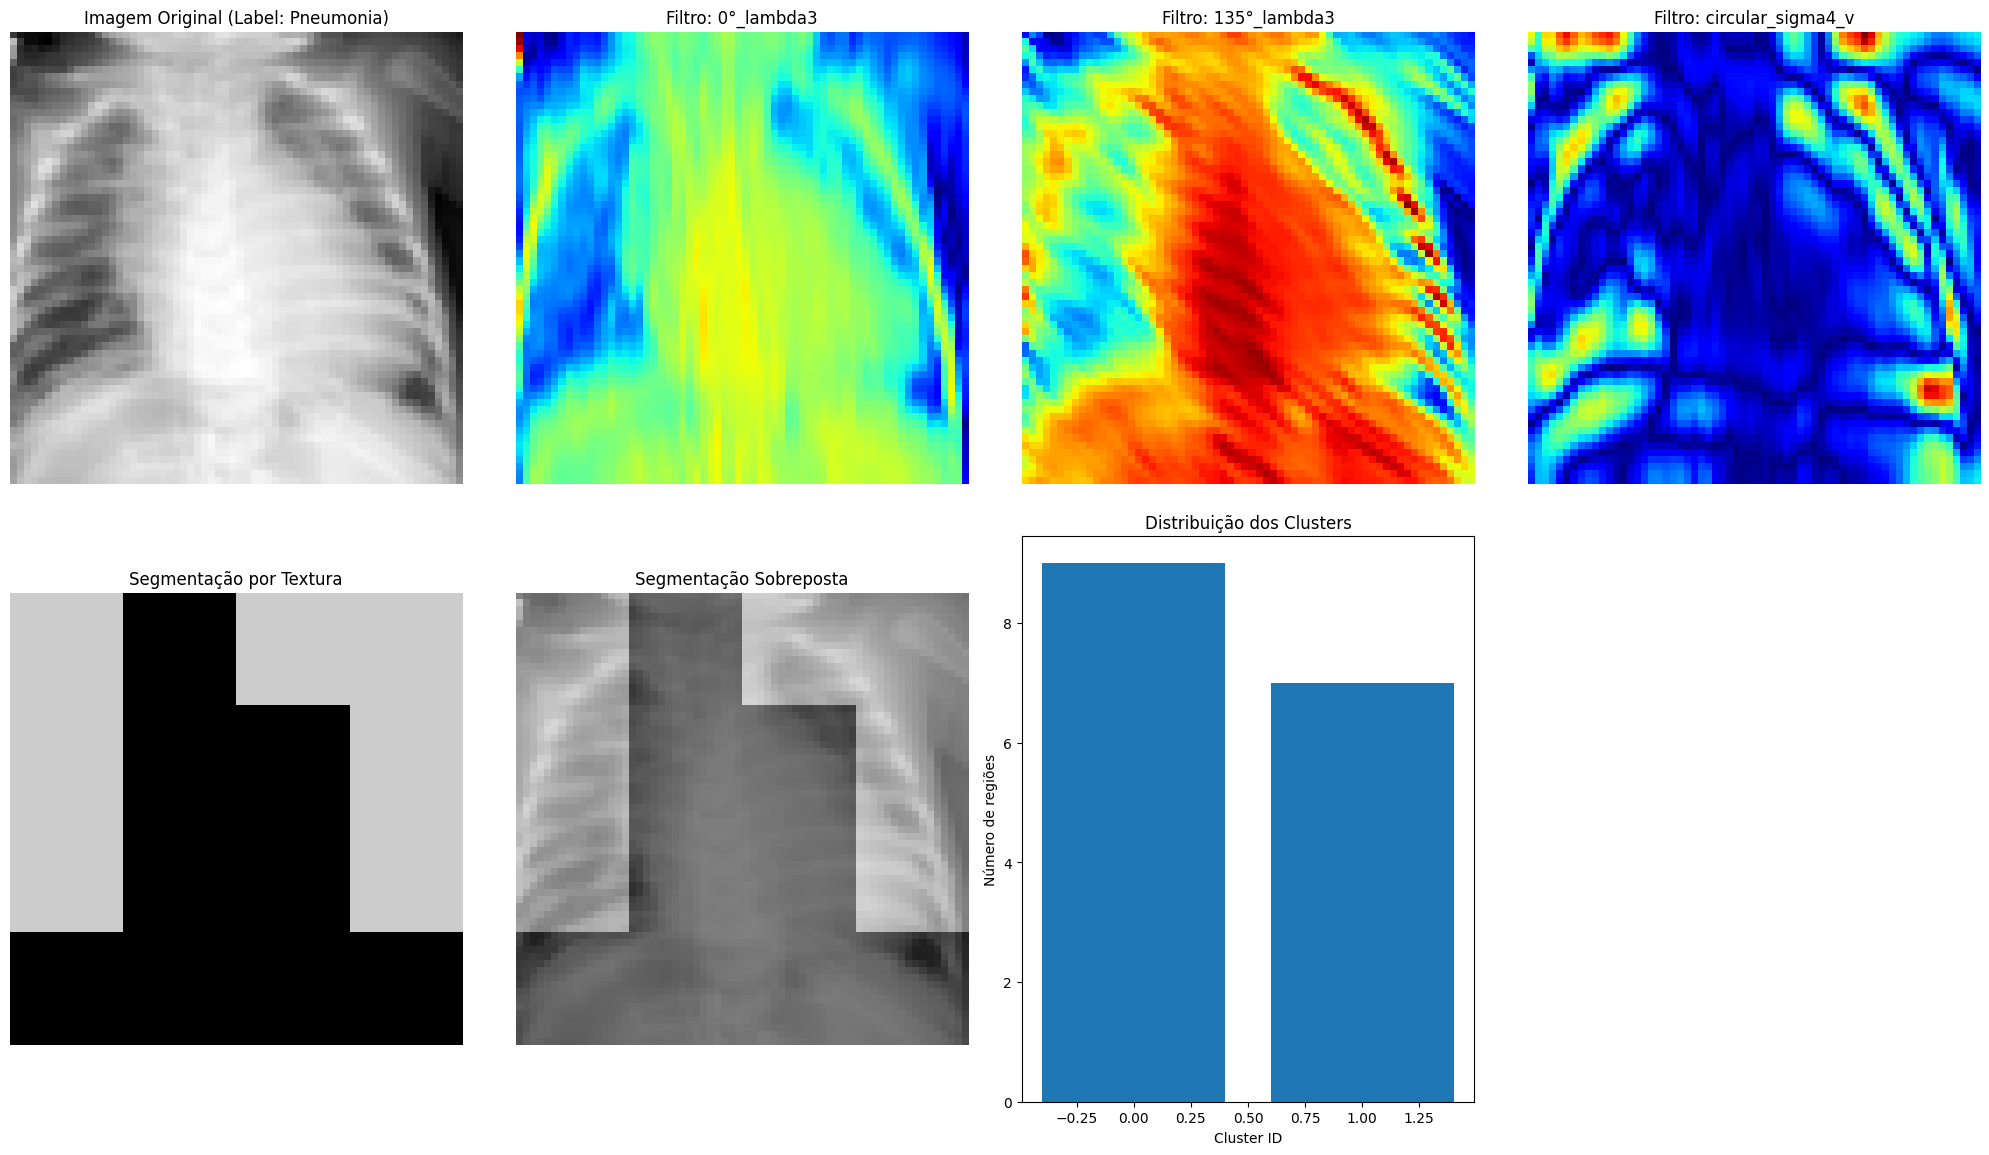

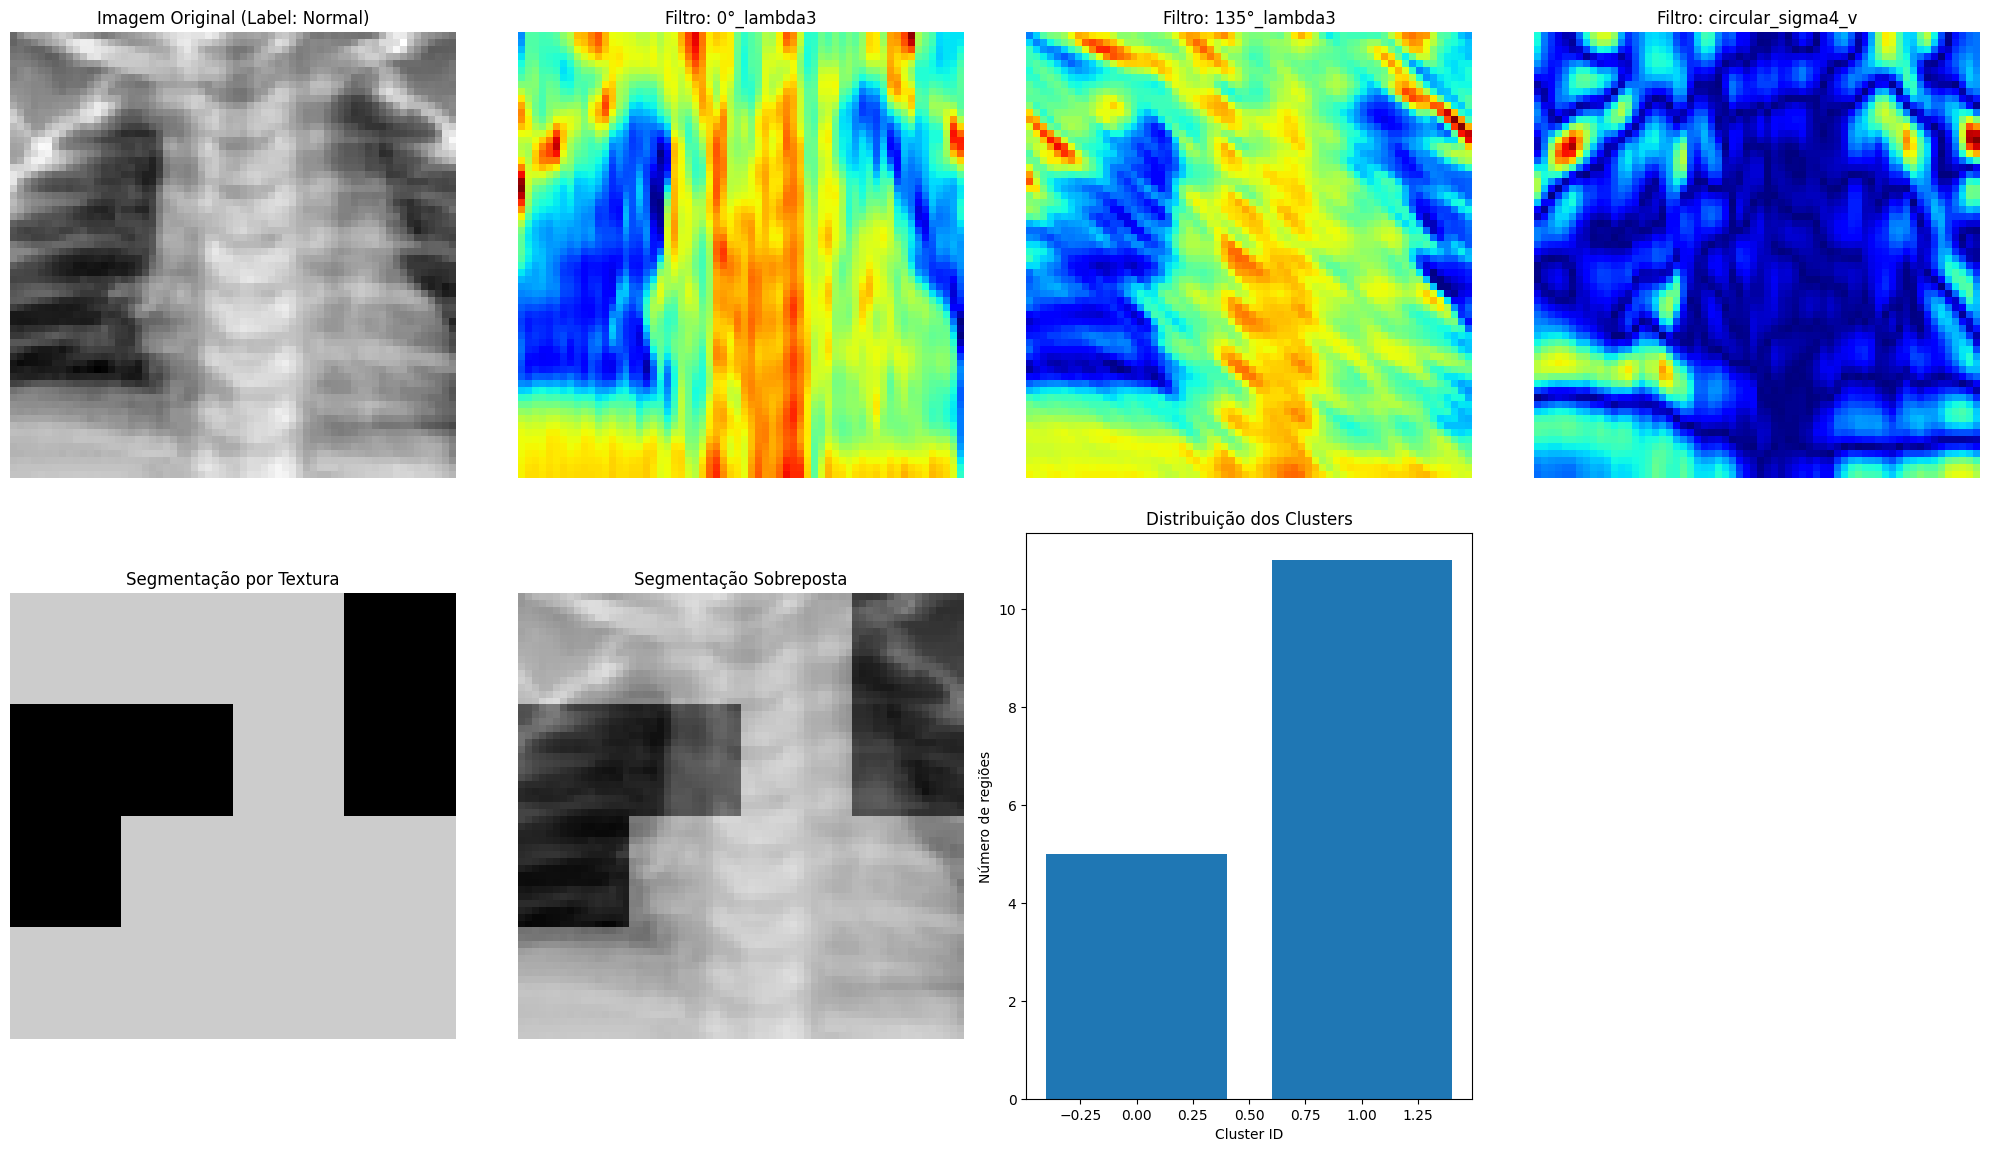

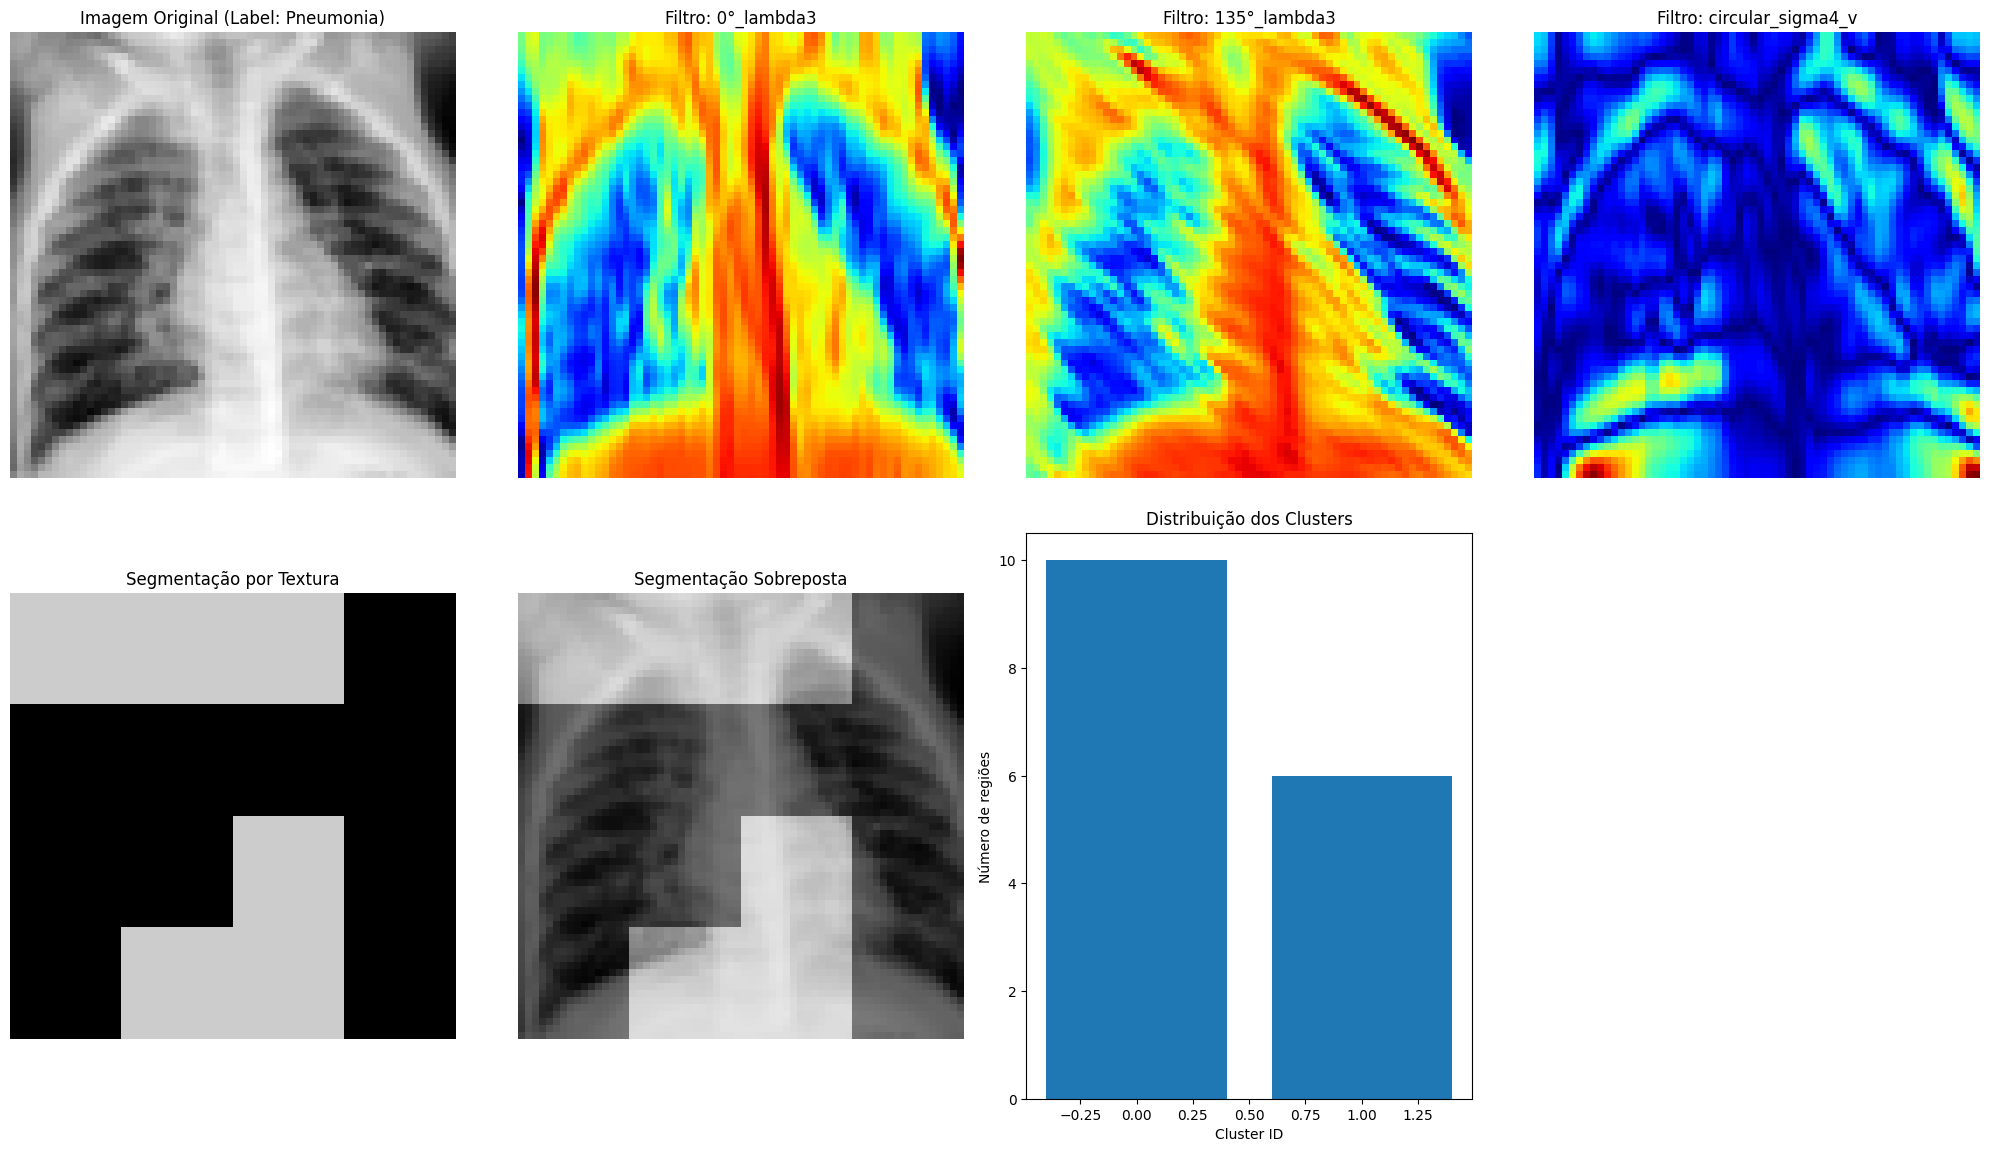

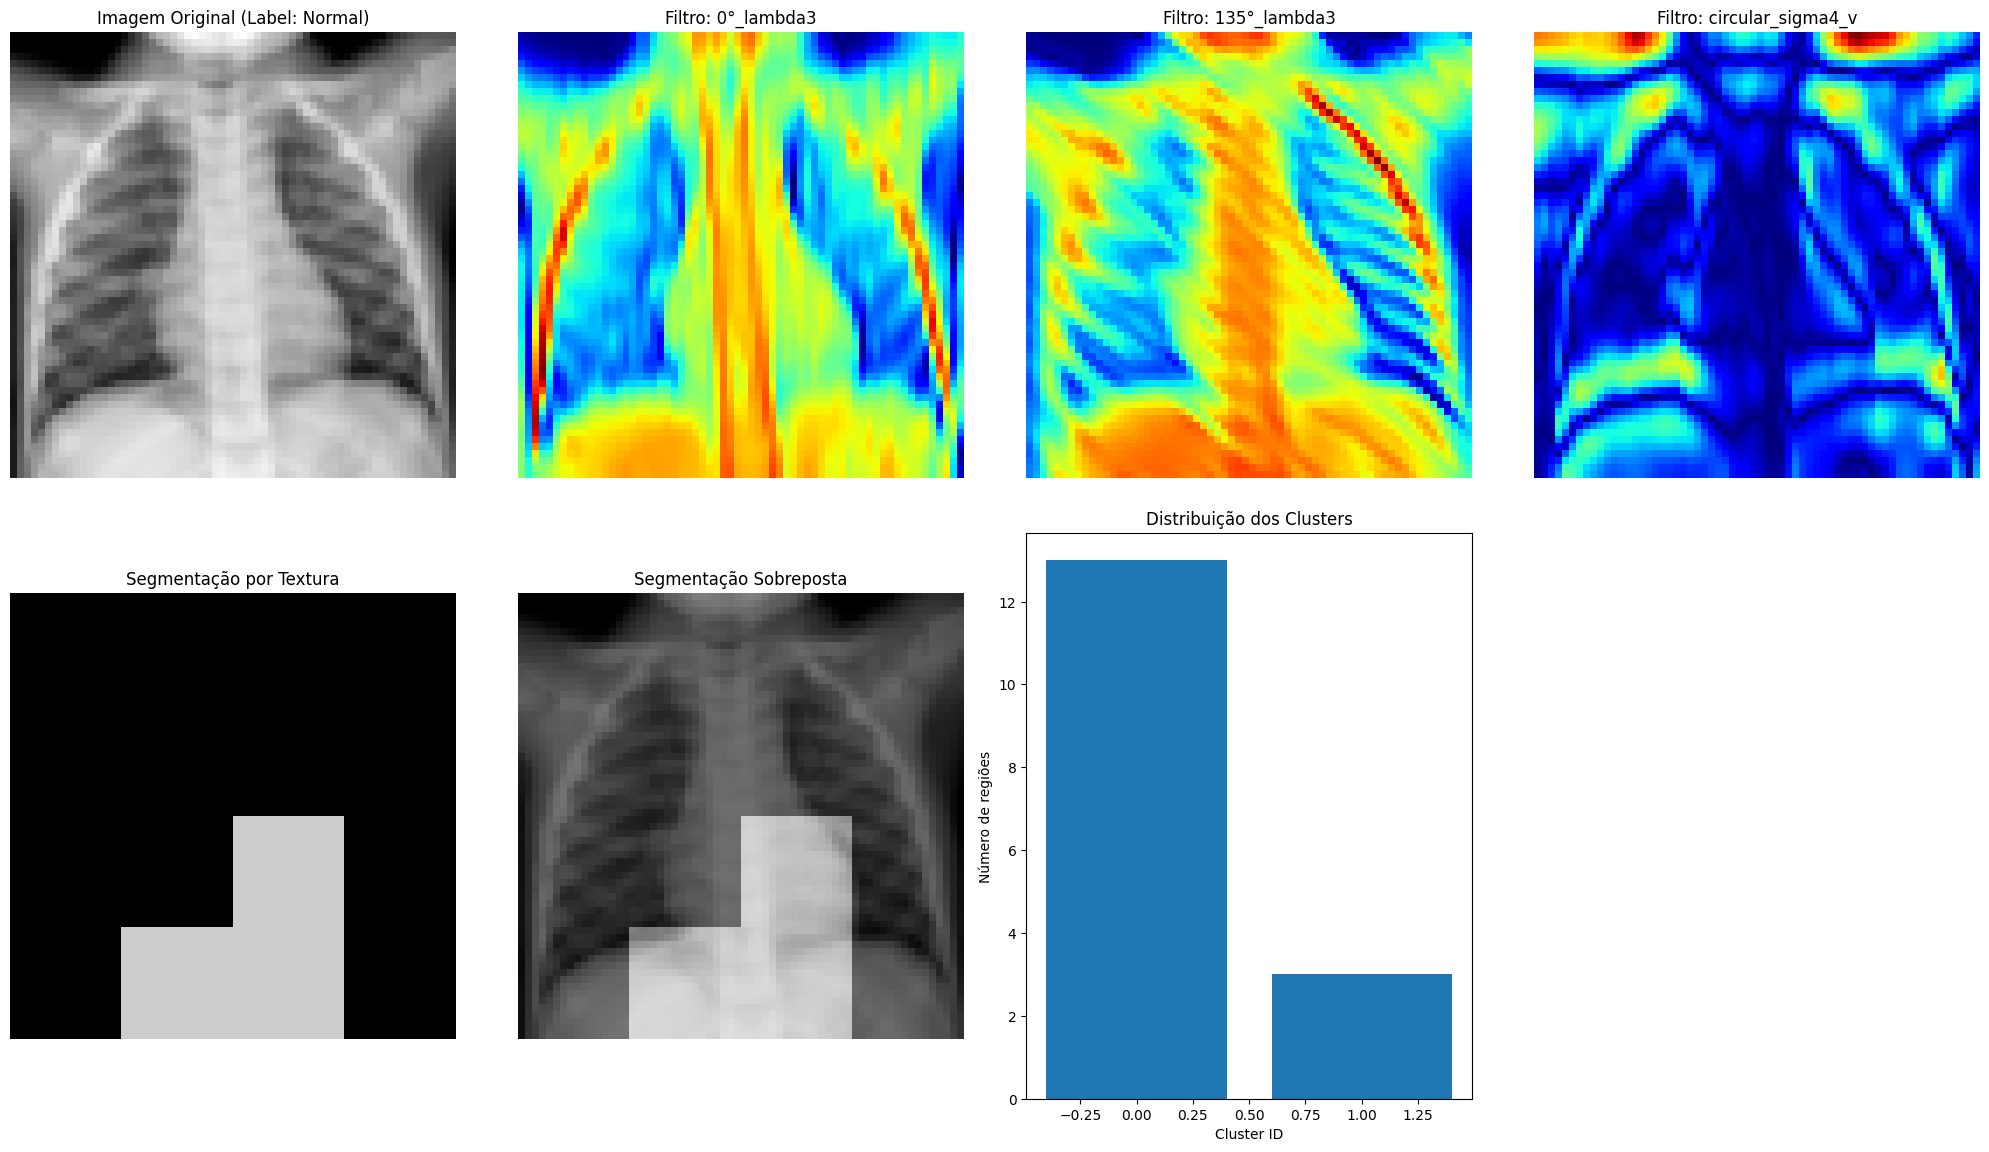

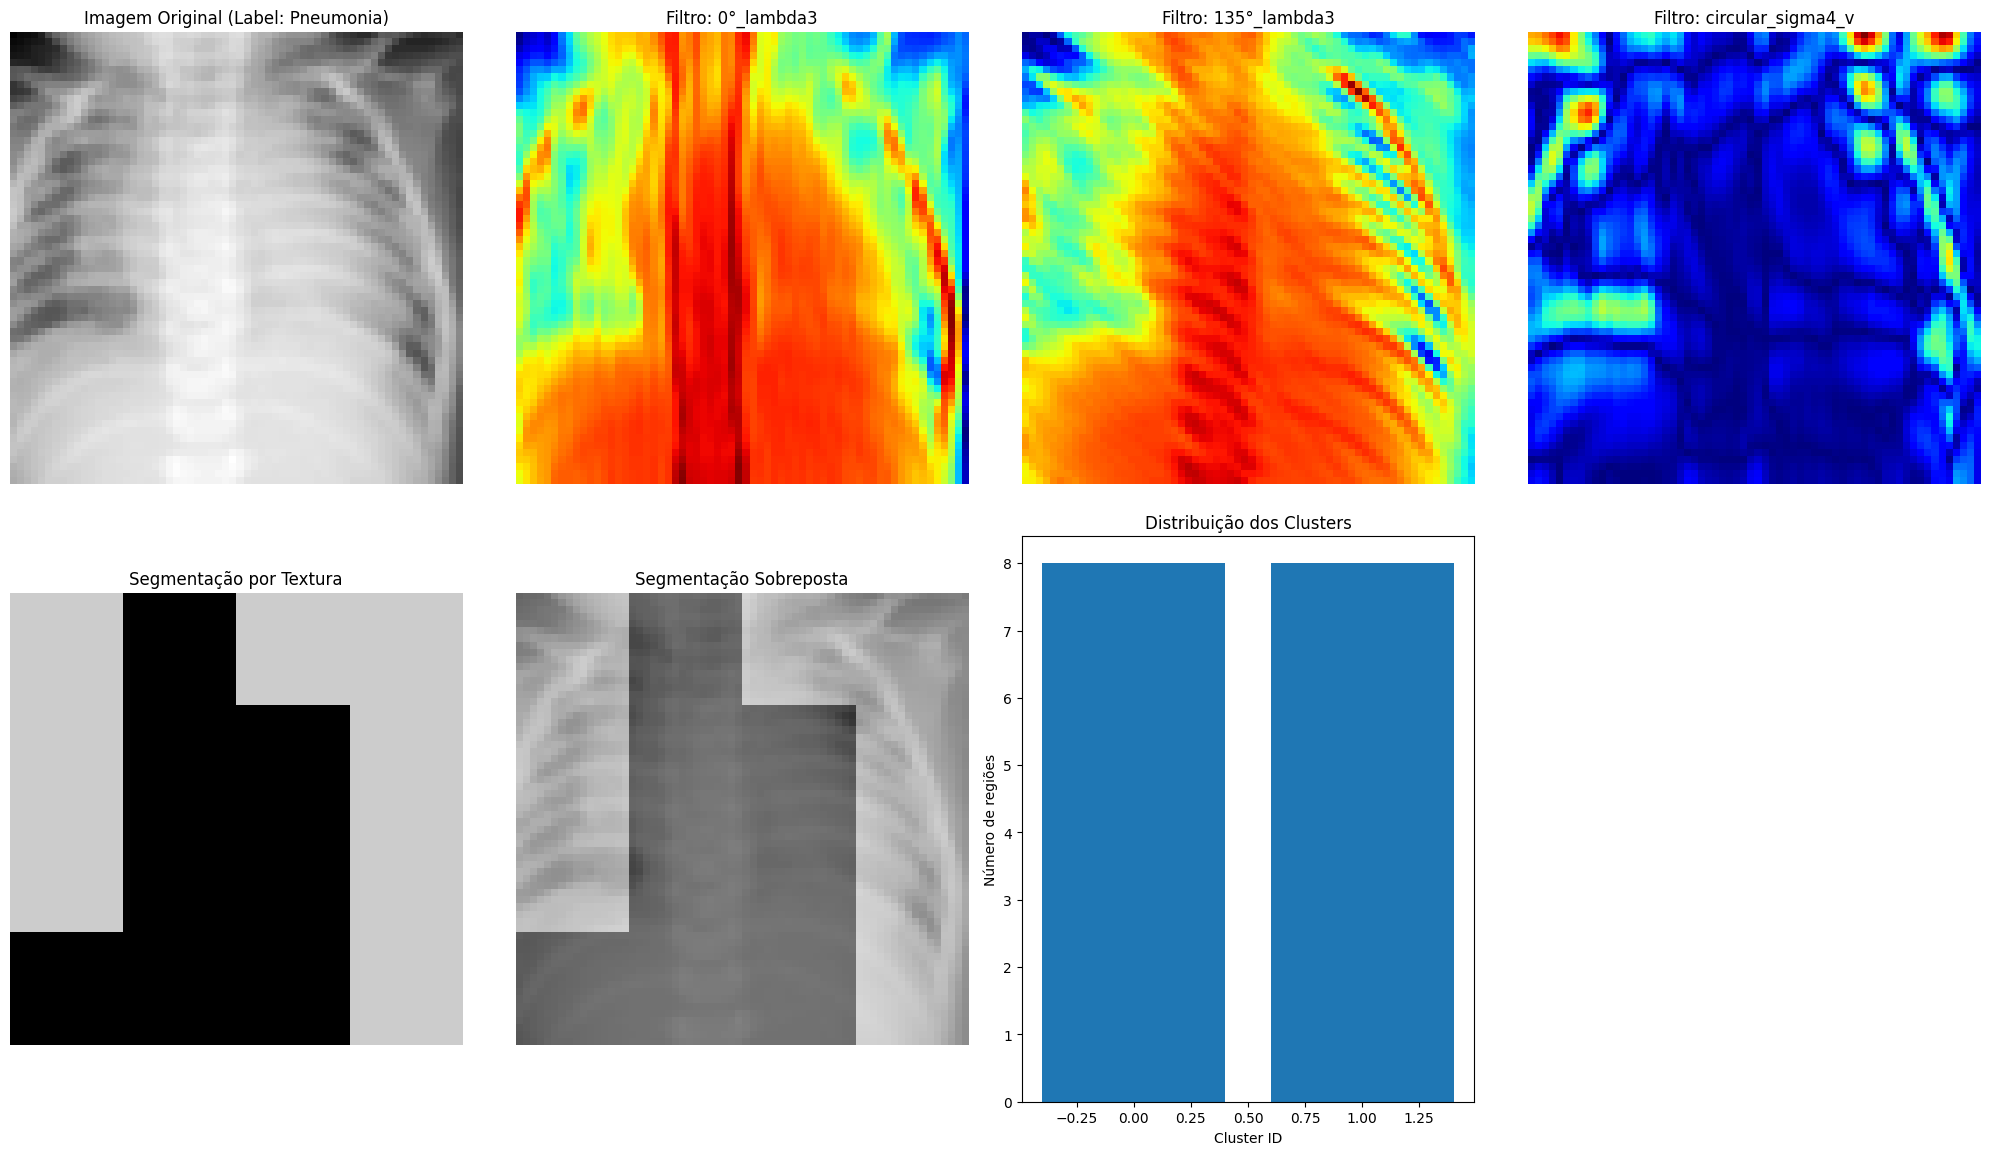

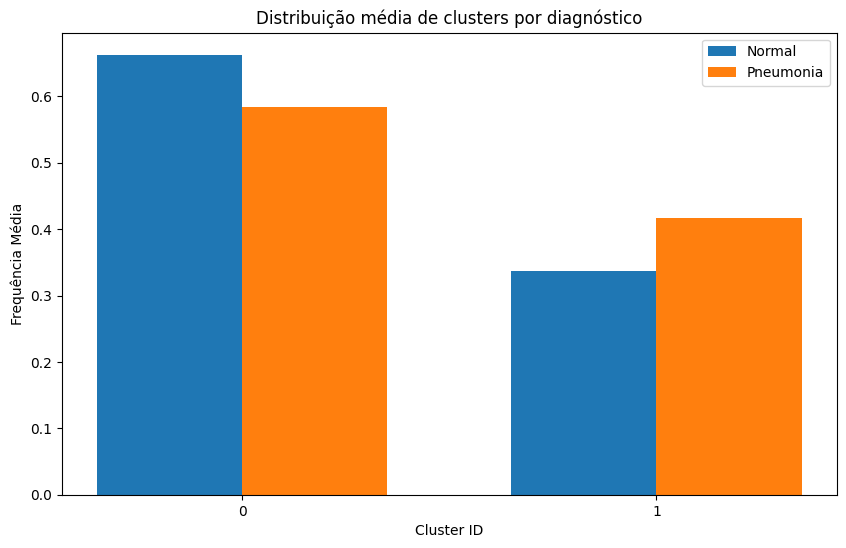


Diferenças na distribuição de clusters entre casos normais e pneumonia:
Cluster 1: Mais comum em pneumonia (Diferença: 0.079)
Cluster 0: Mais comum em normal (Diferença: 0.079)

Processando com filtros em múltiplas escalas...


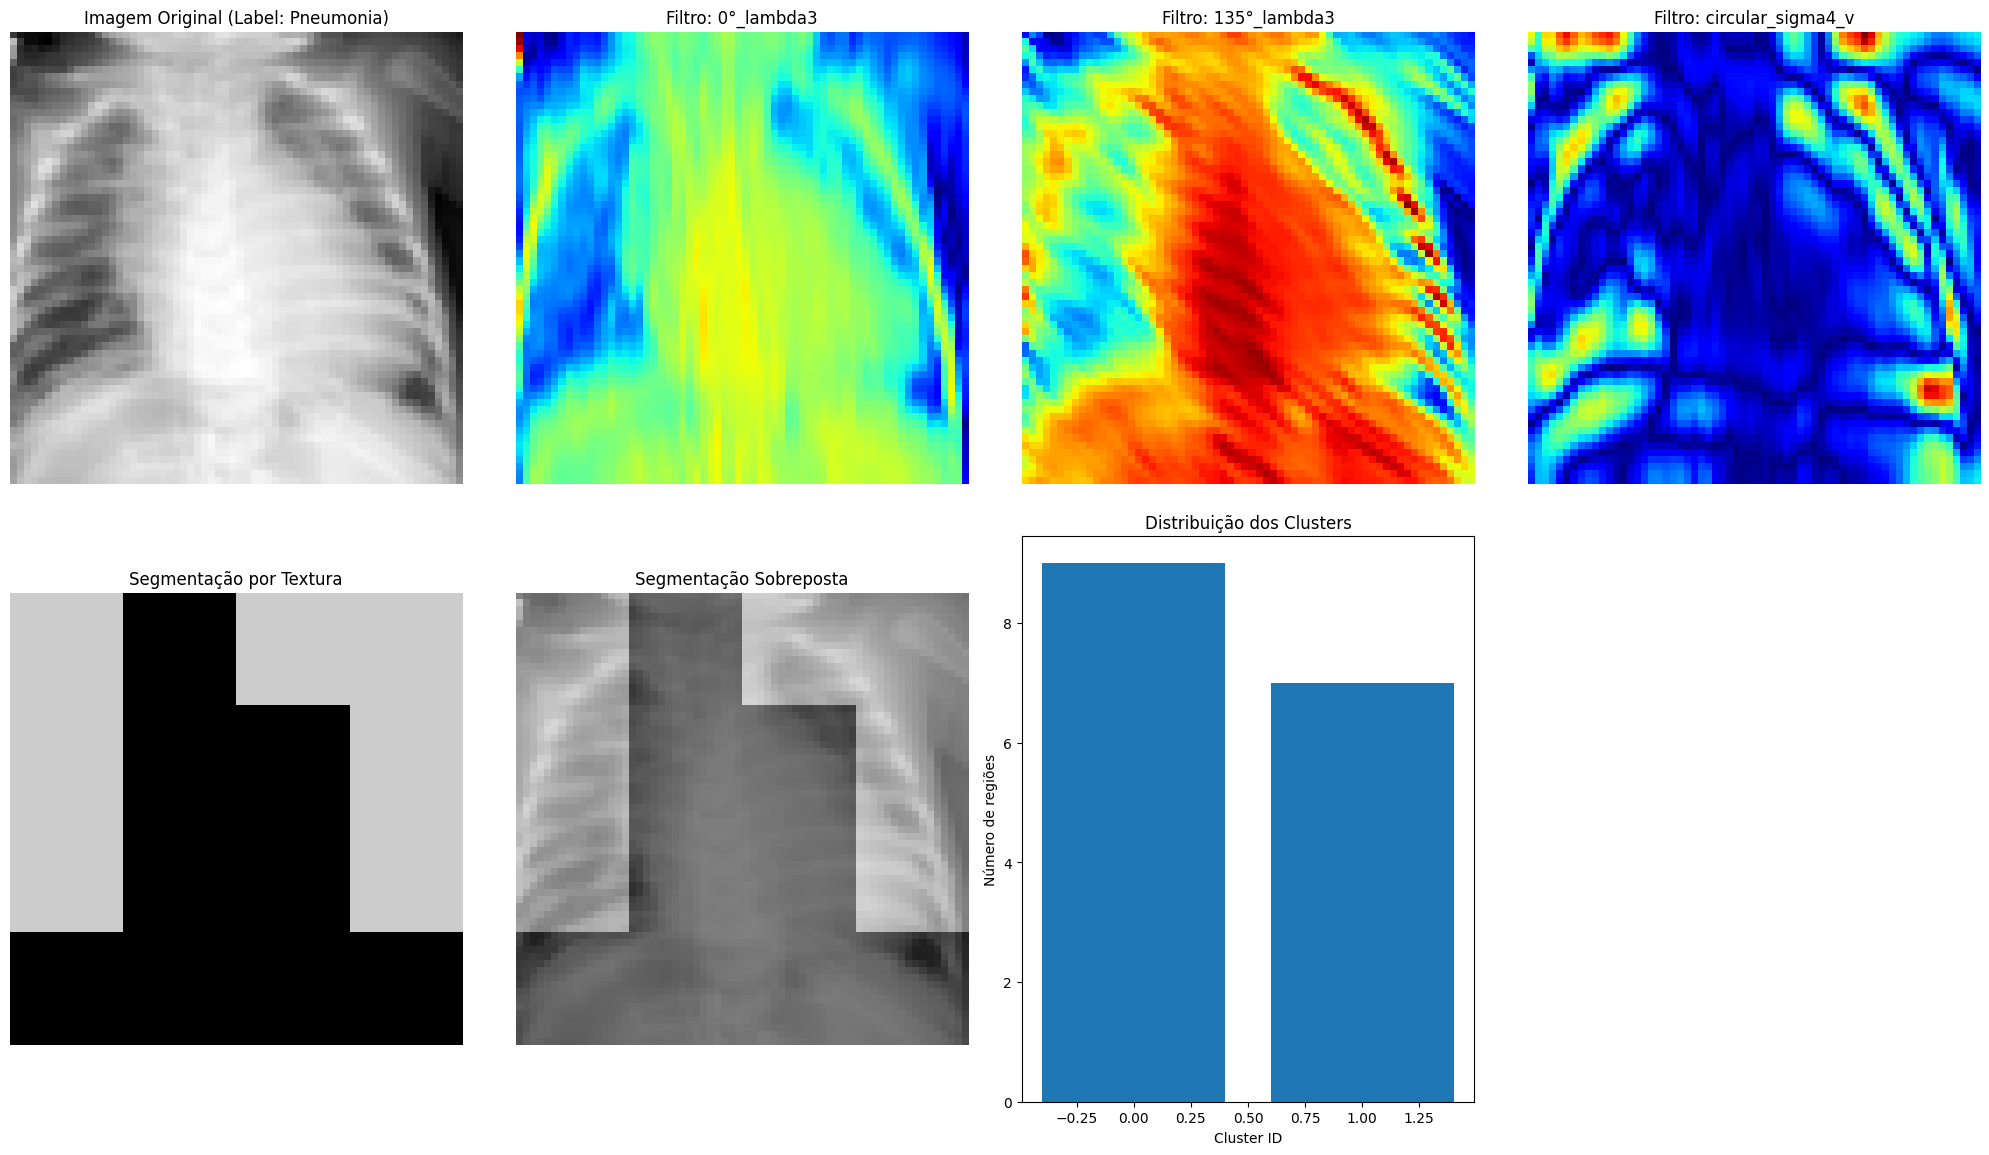


Processando com filtros em múltiplas escalas...


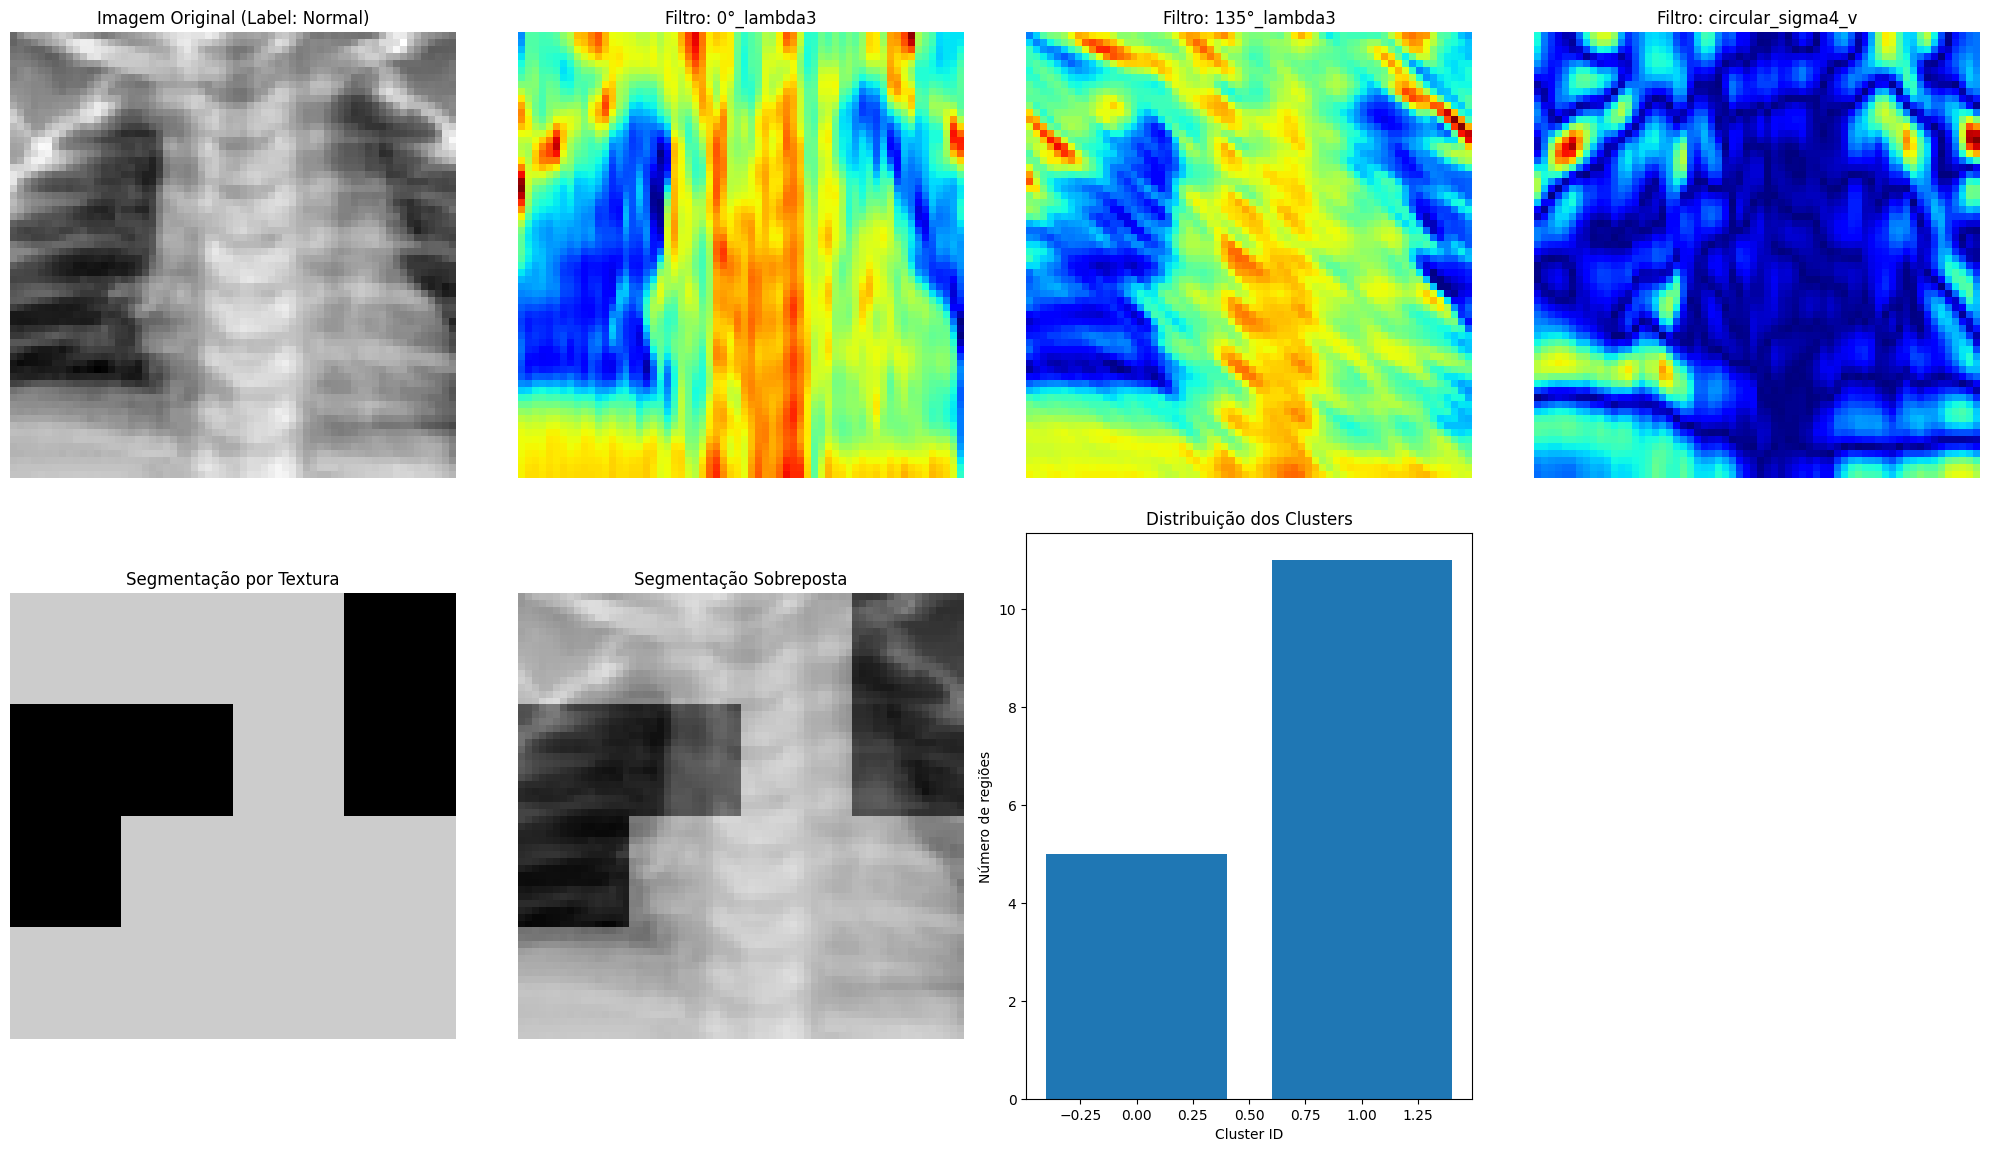


Processando com filtros em múltiplas escalas...


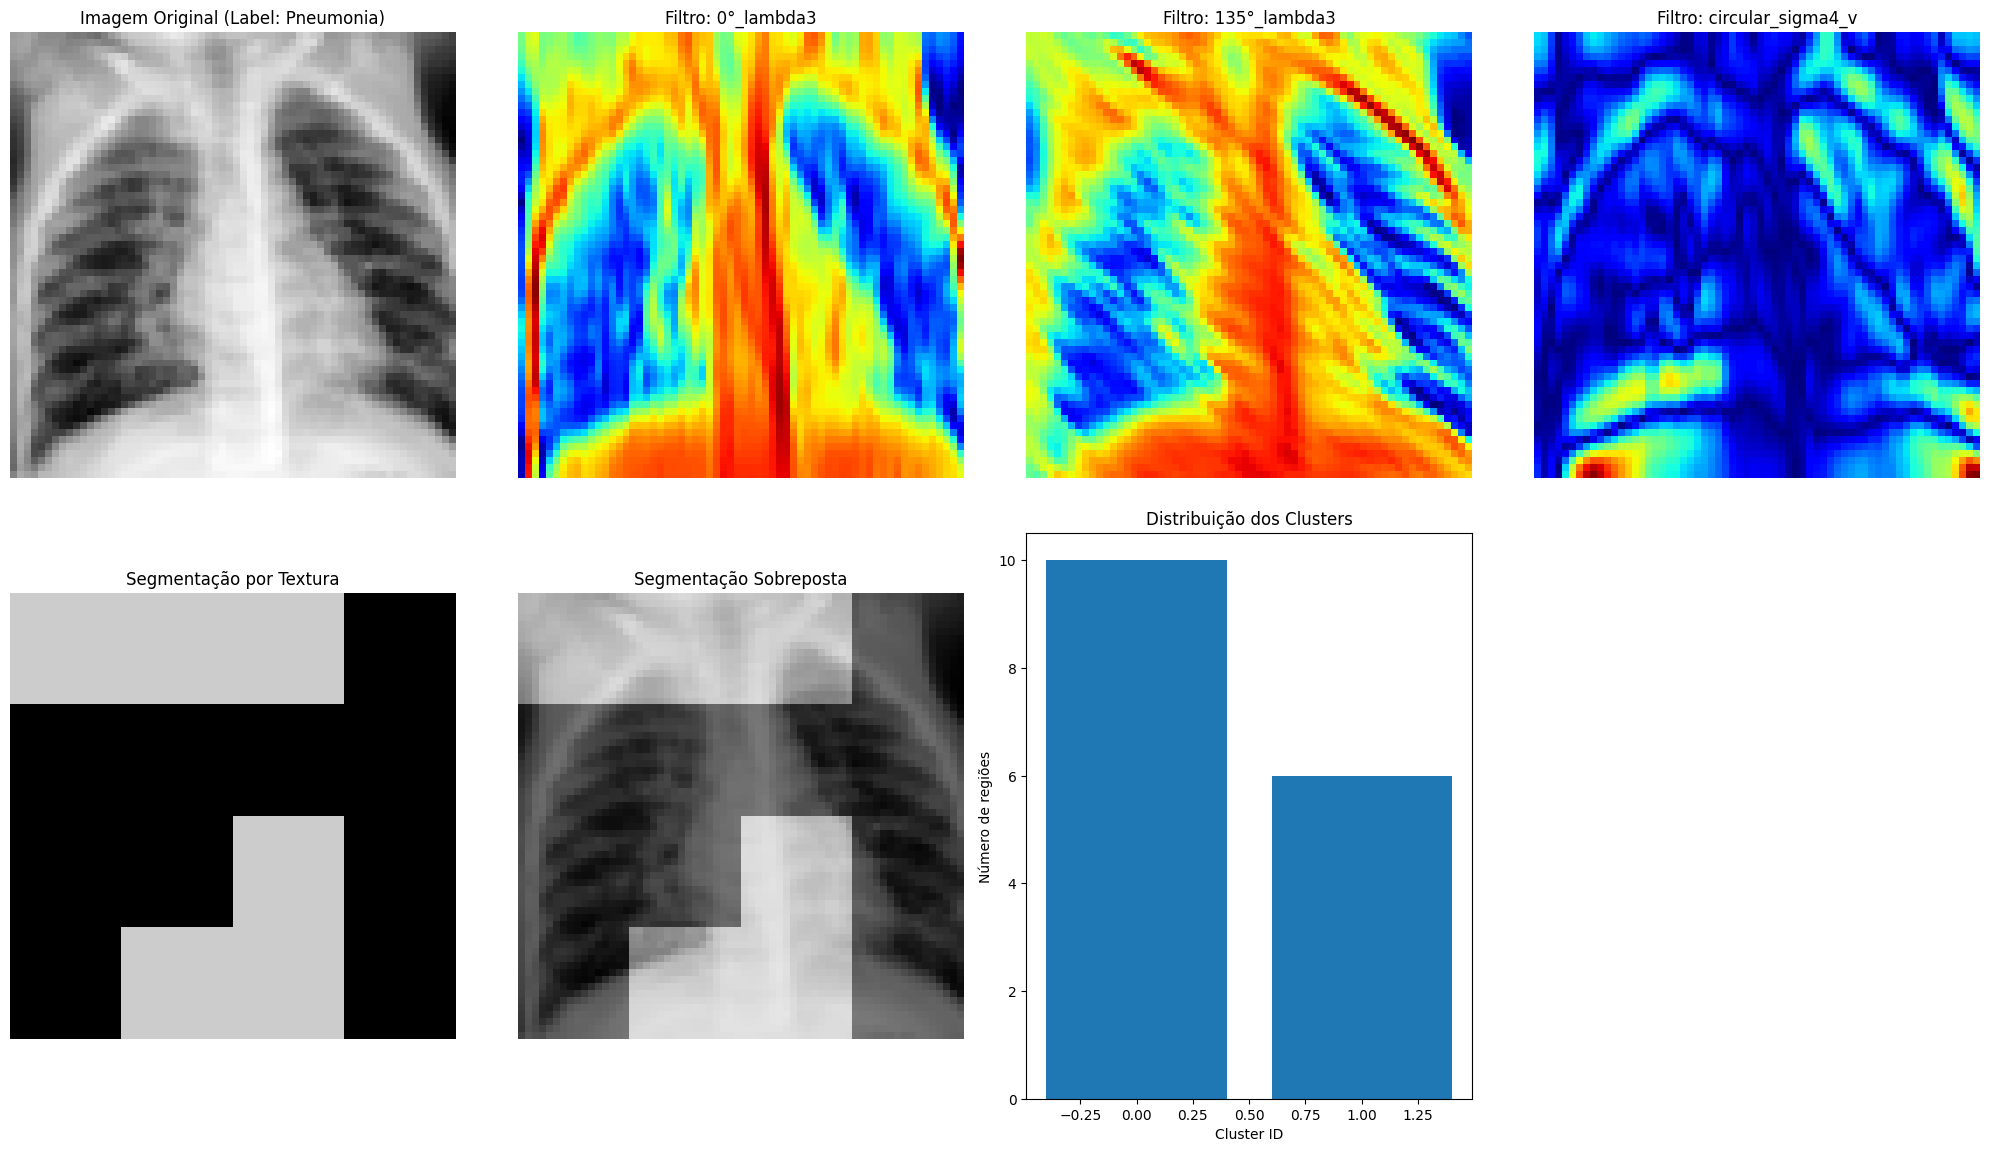


Processando com filtros em múltiplas escalas...


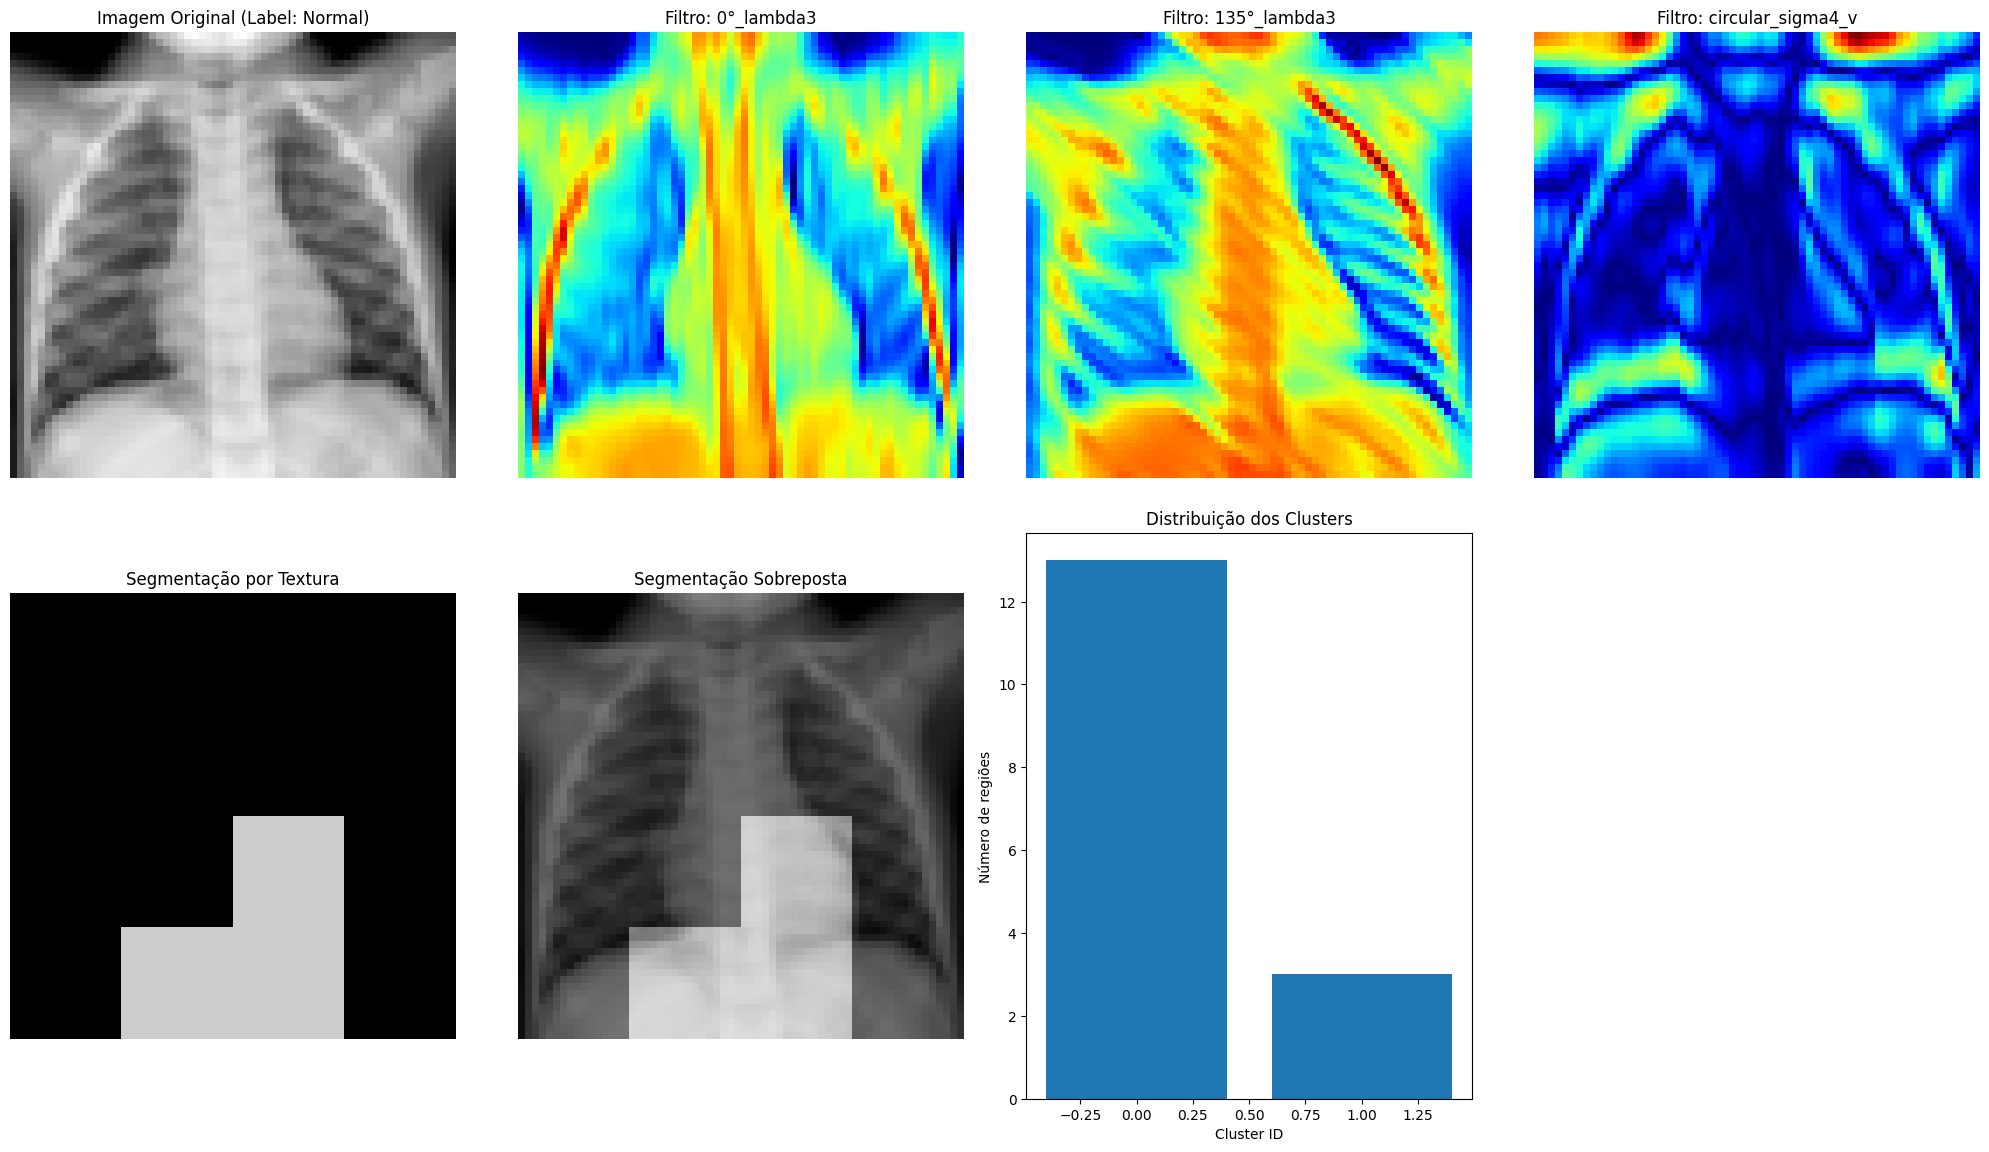


Processando com filtros em múltiplas escalas...


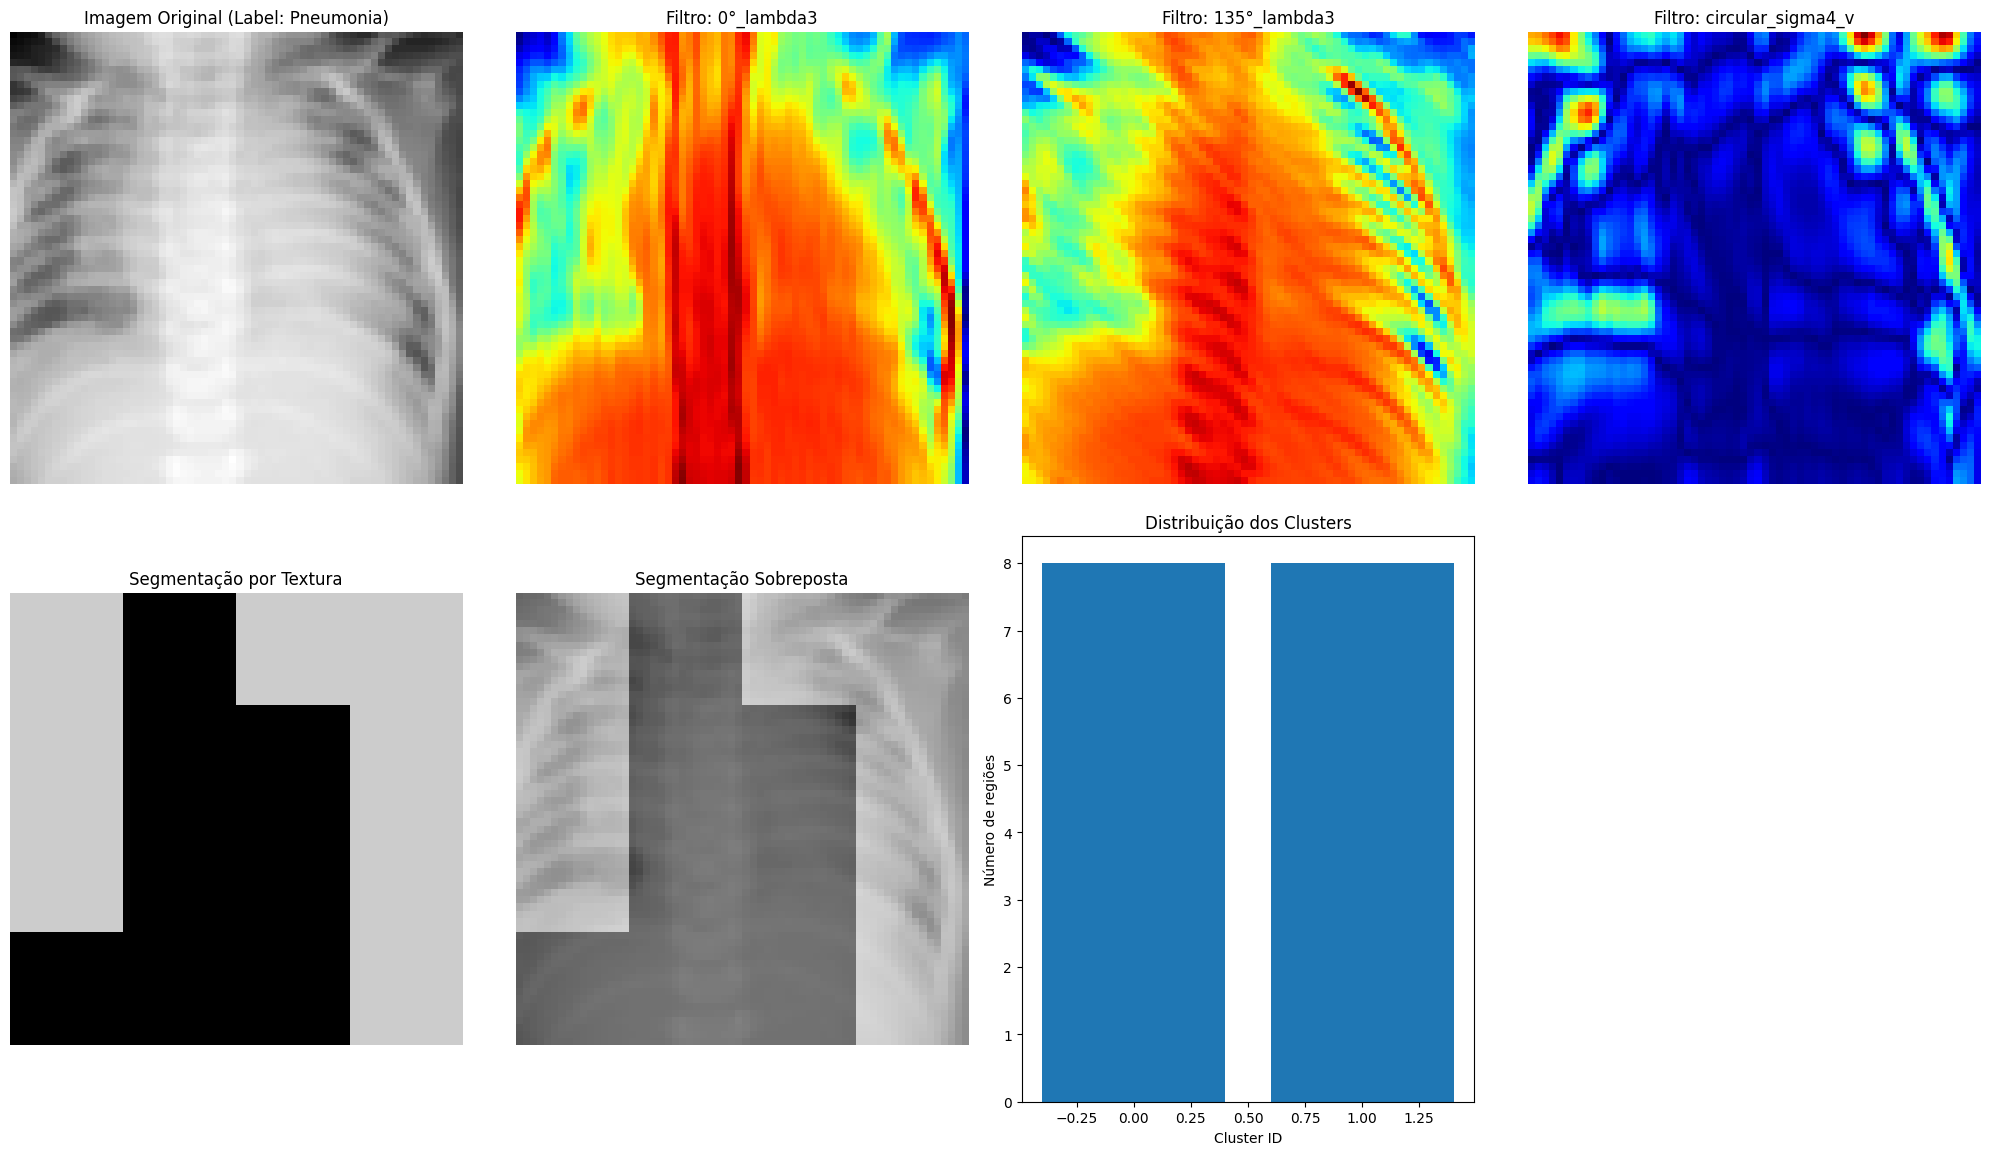


Processando com filtros em múltiplas escalas...


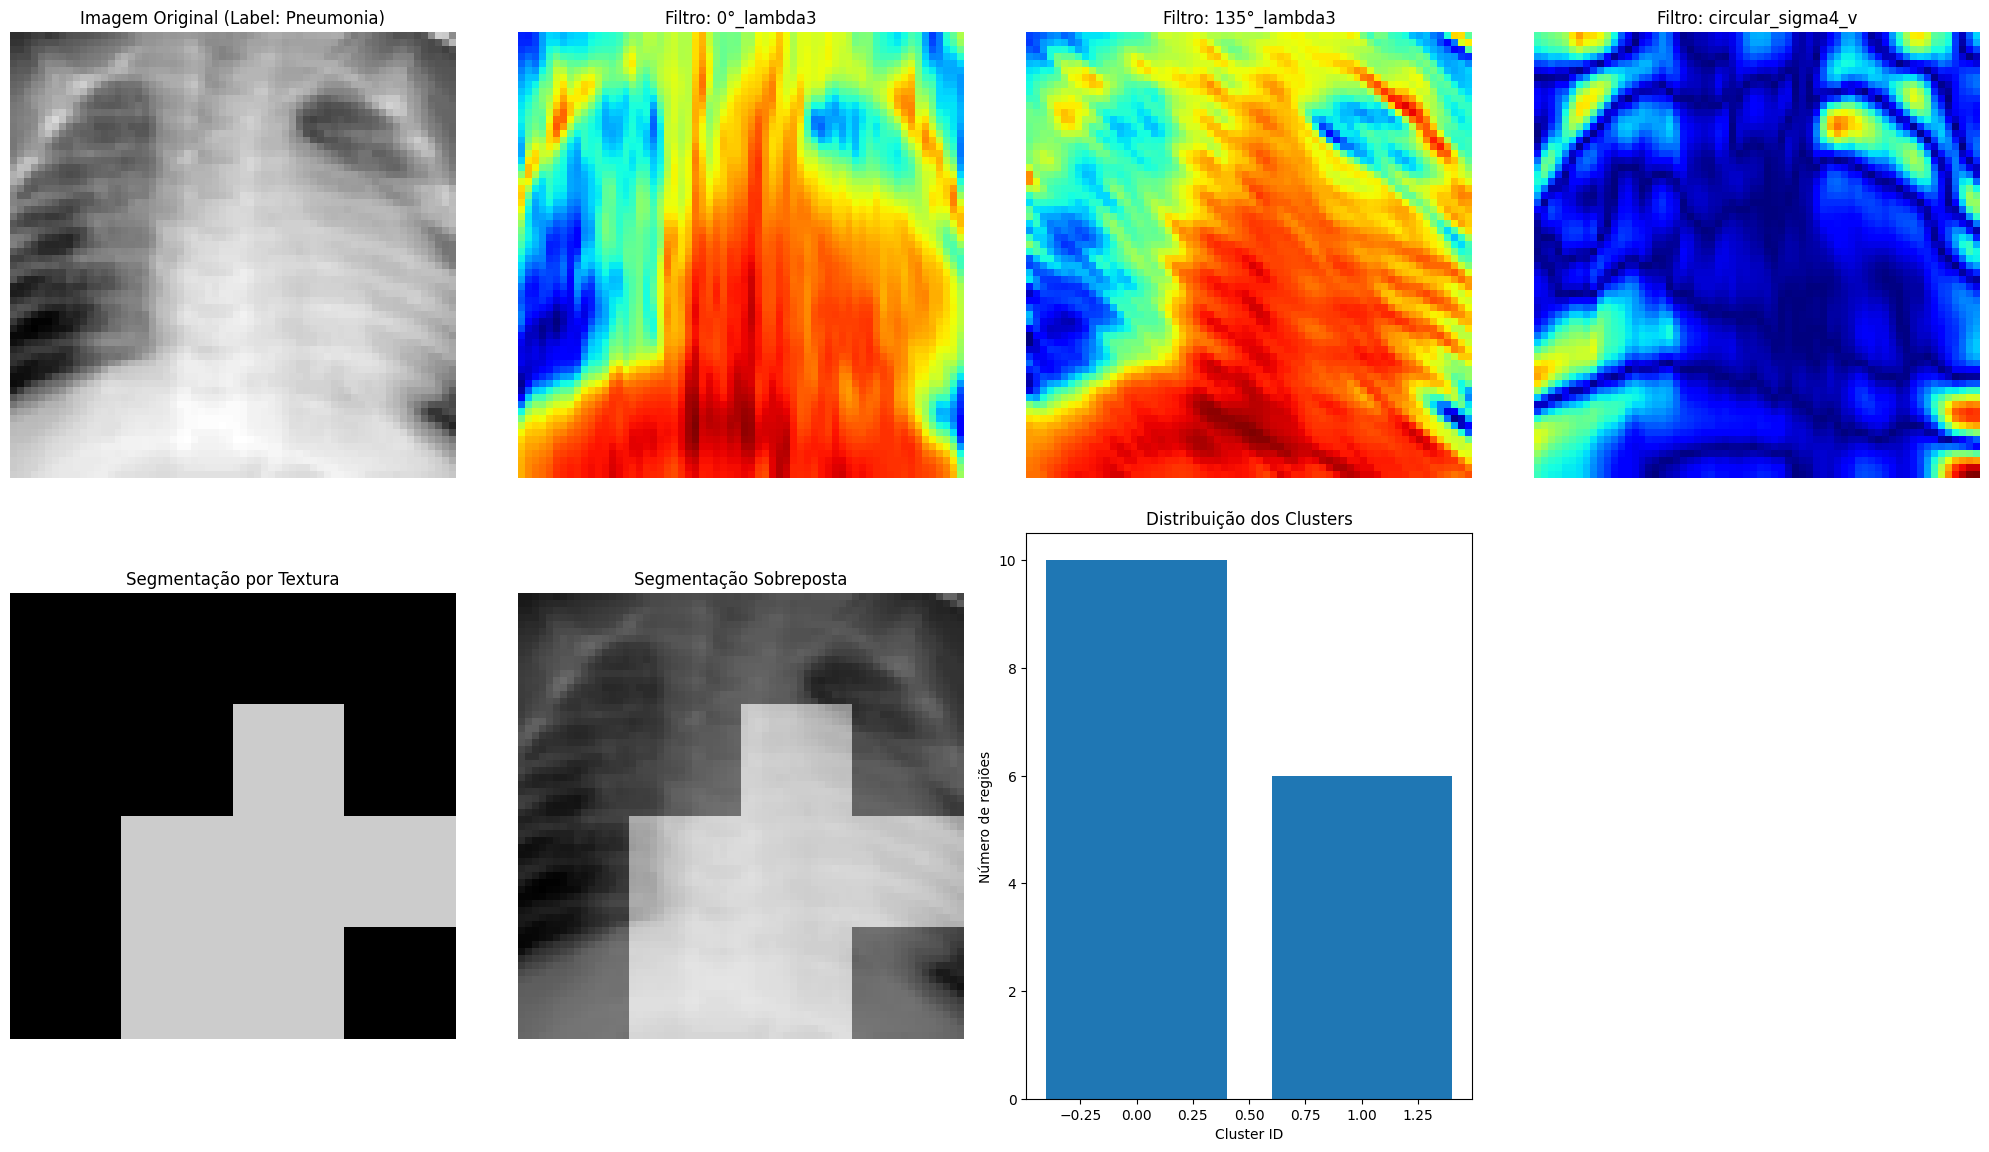


Processando com filtros em múltiplas escalas...


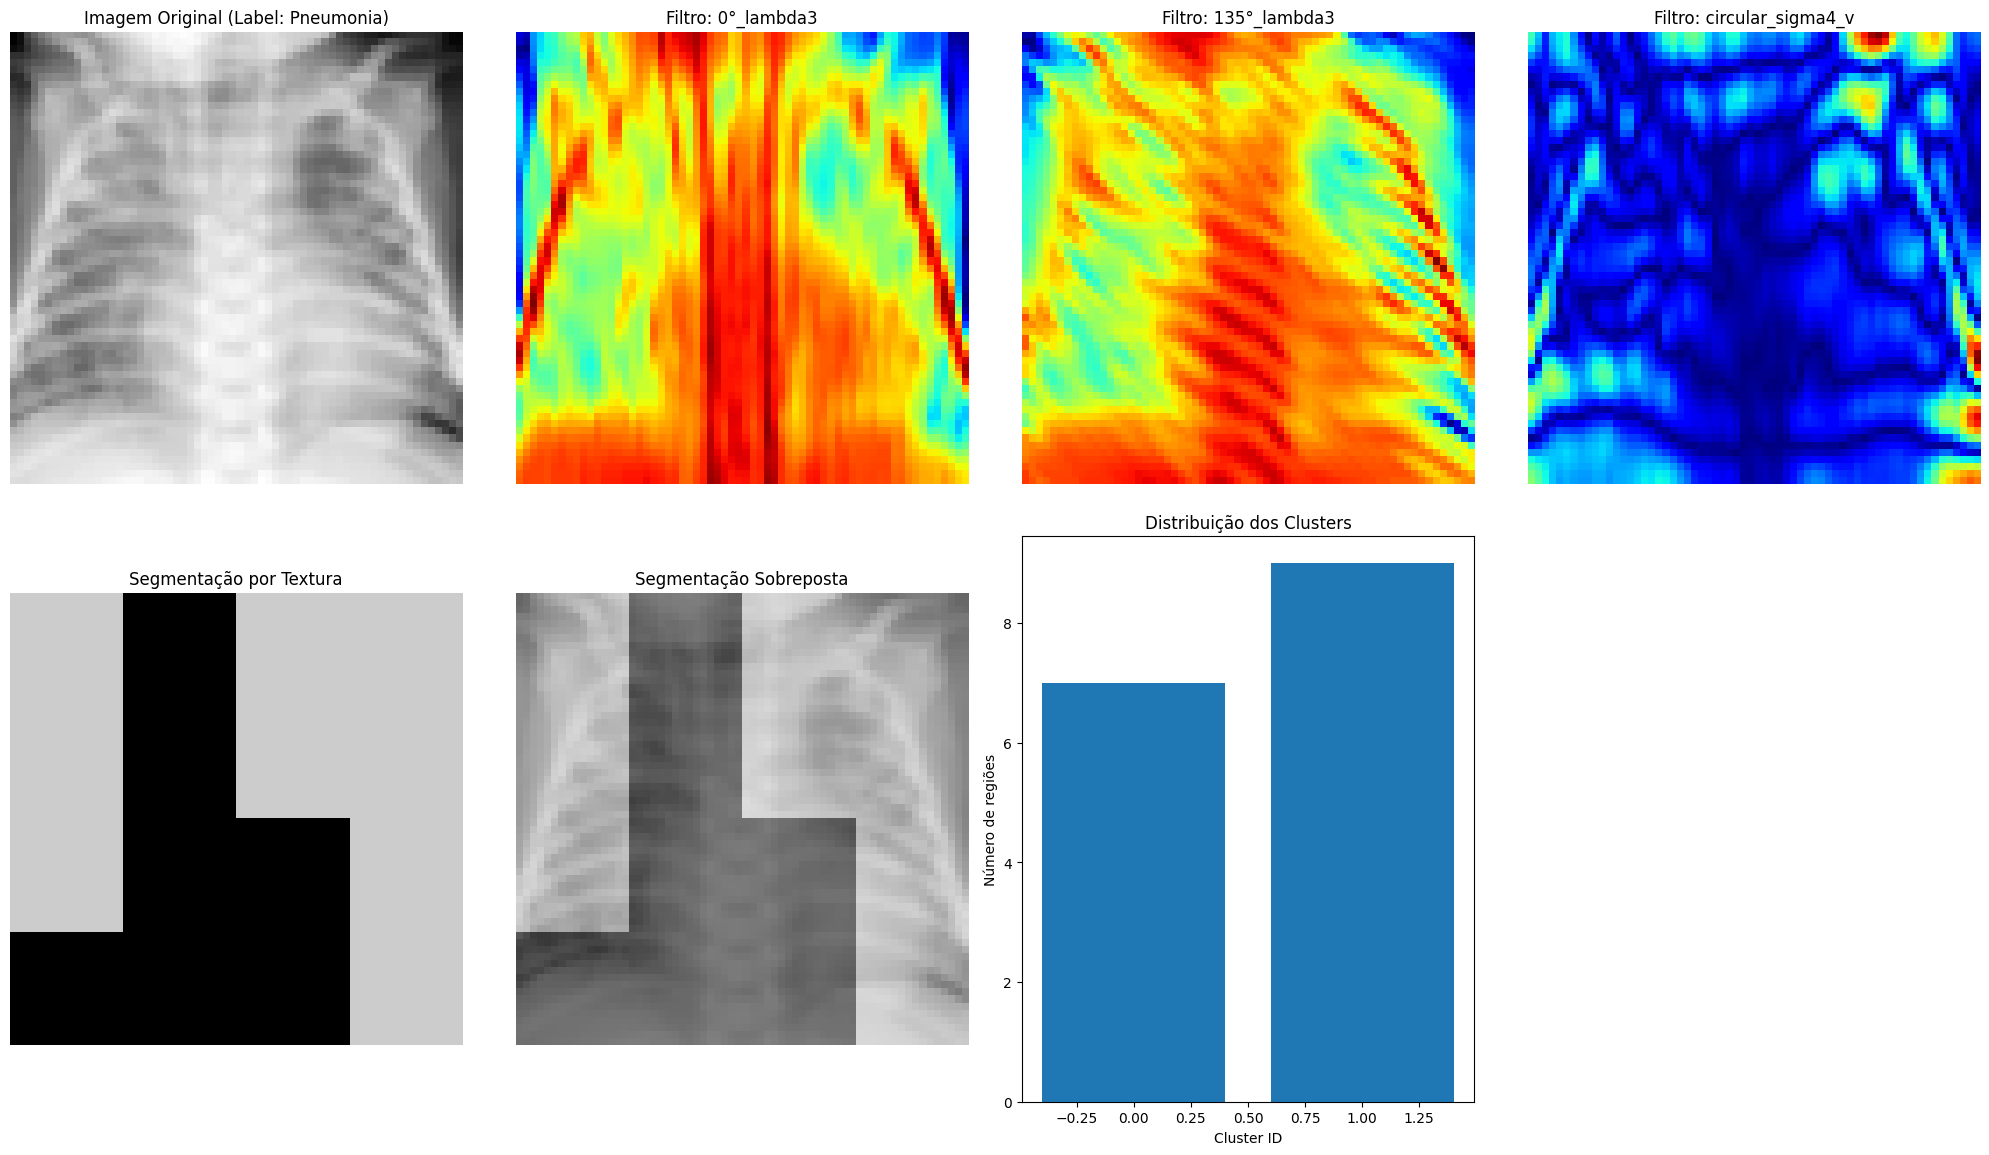


Processando com filtros em múltiplas escalas...


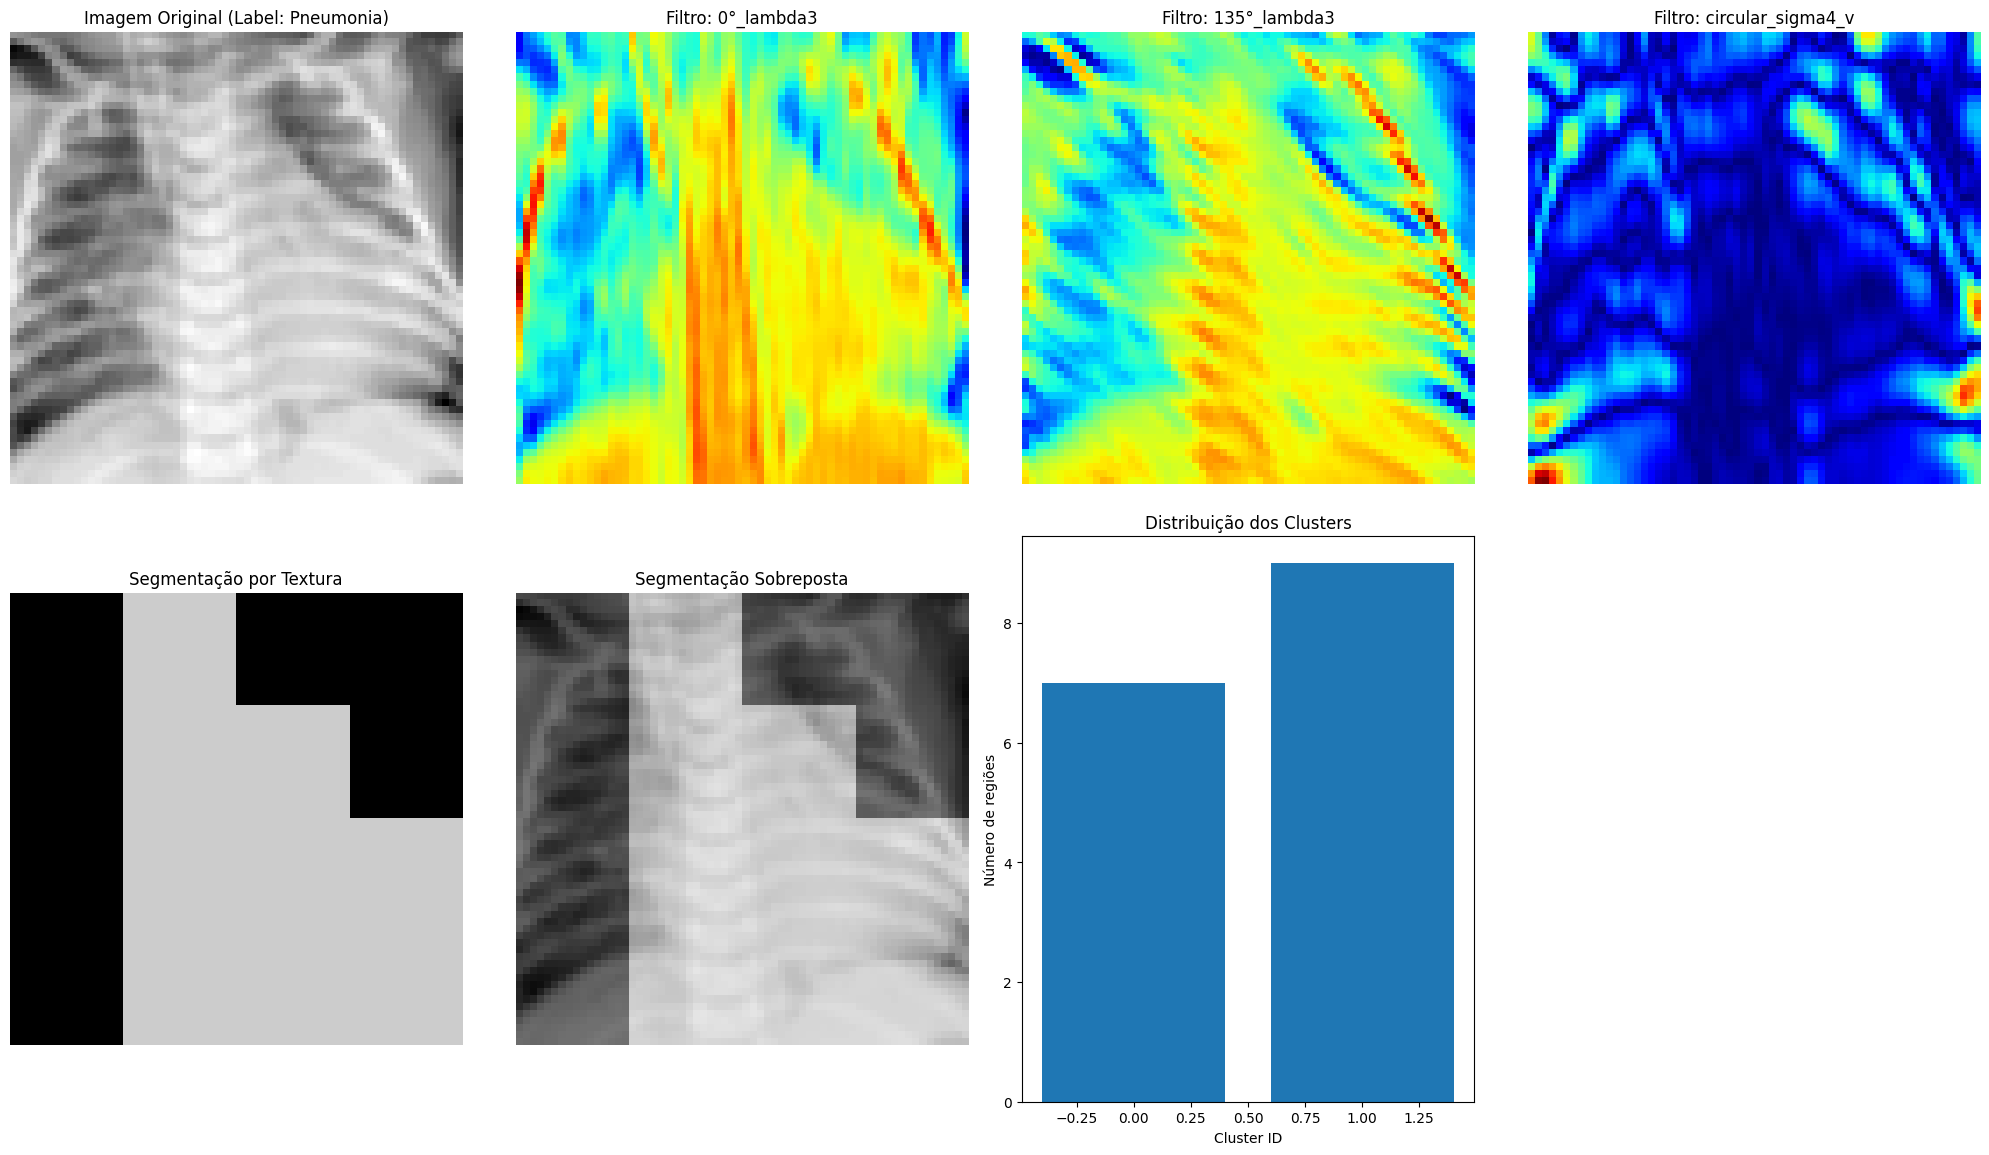


Processando com filtros em múltiplas escalas...


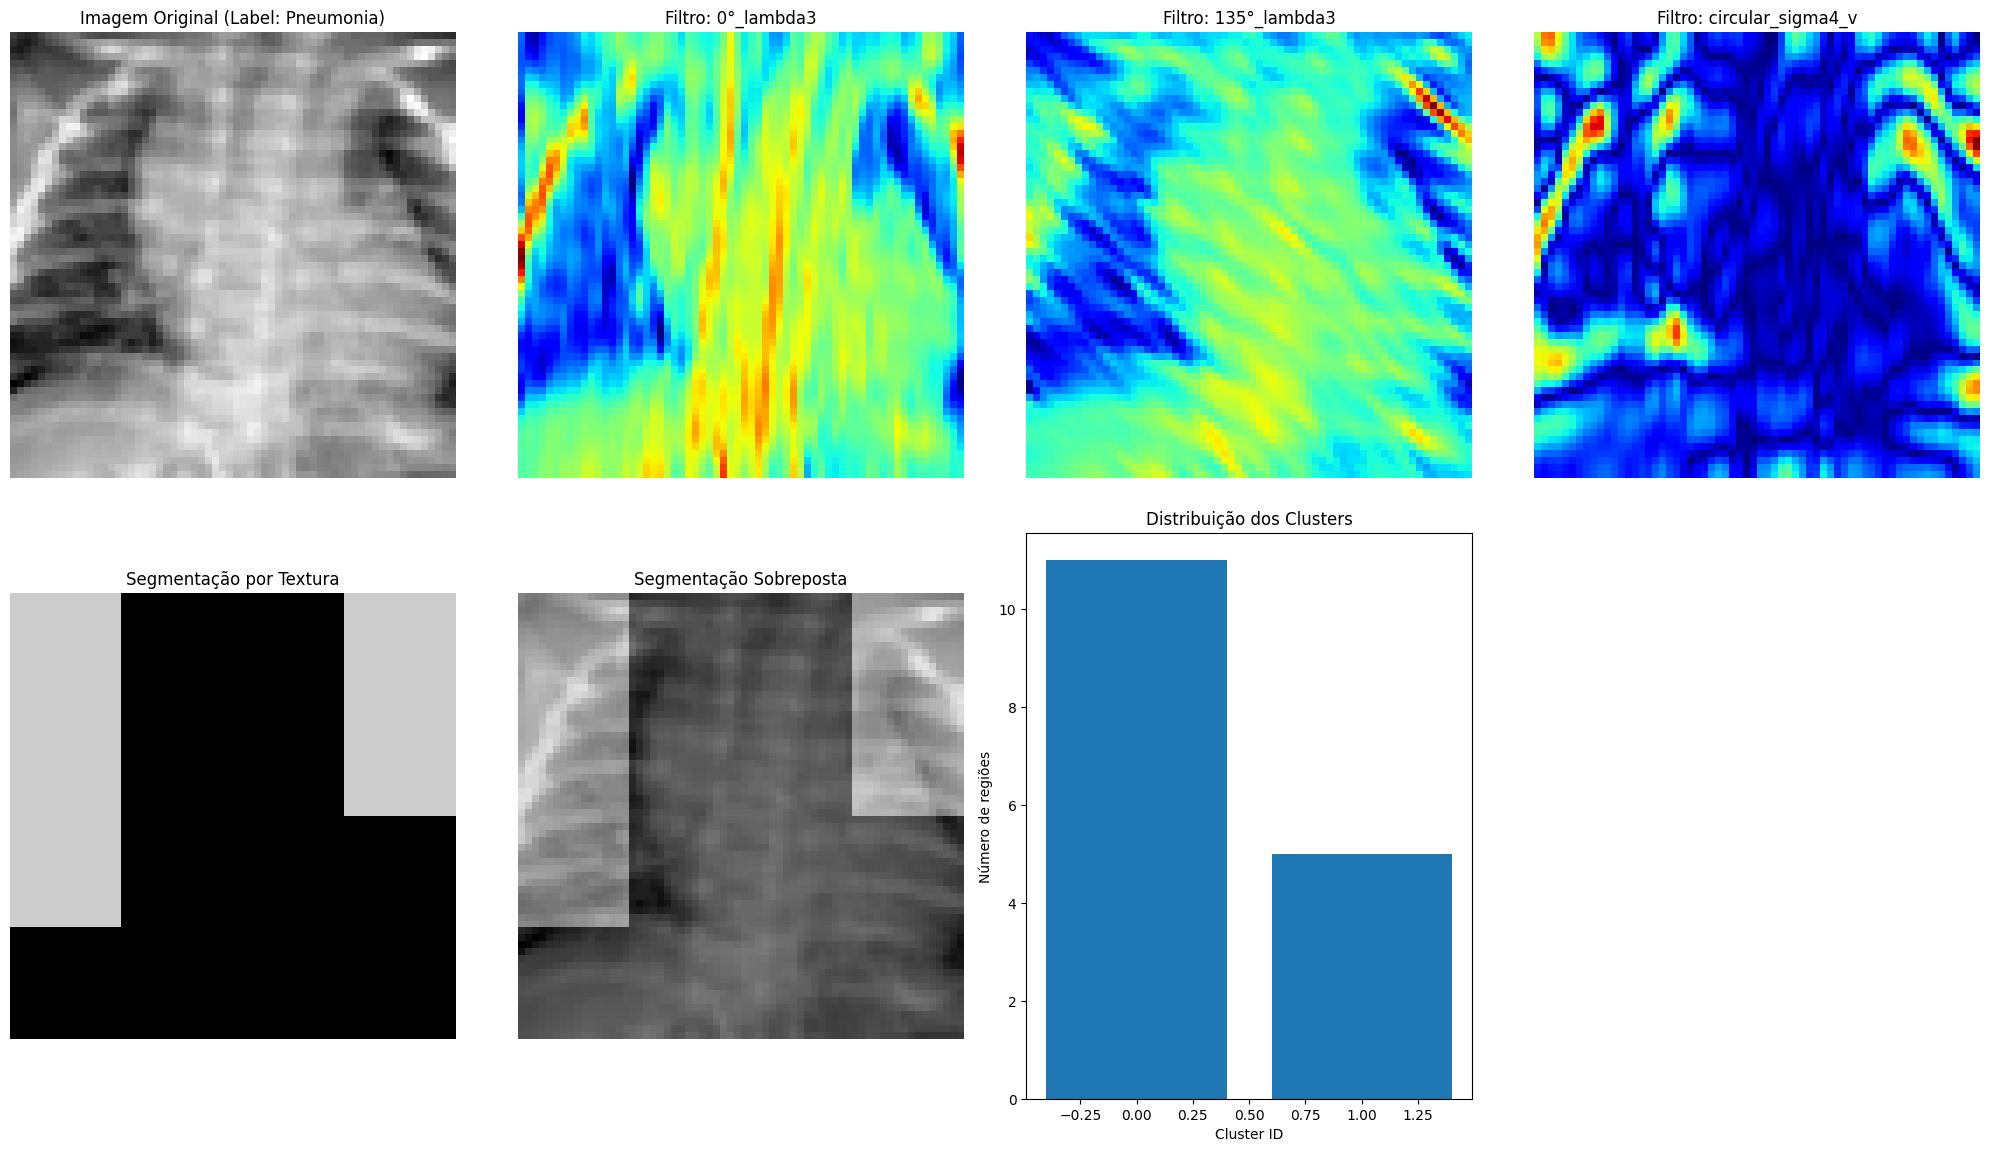


Processando com filtros em múltiplas escalas...


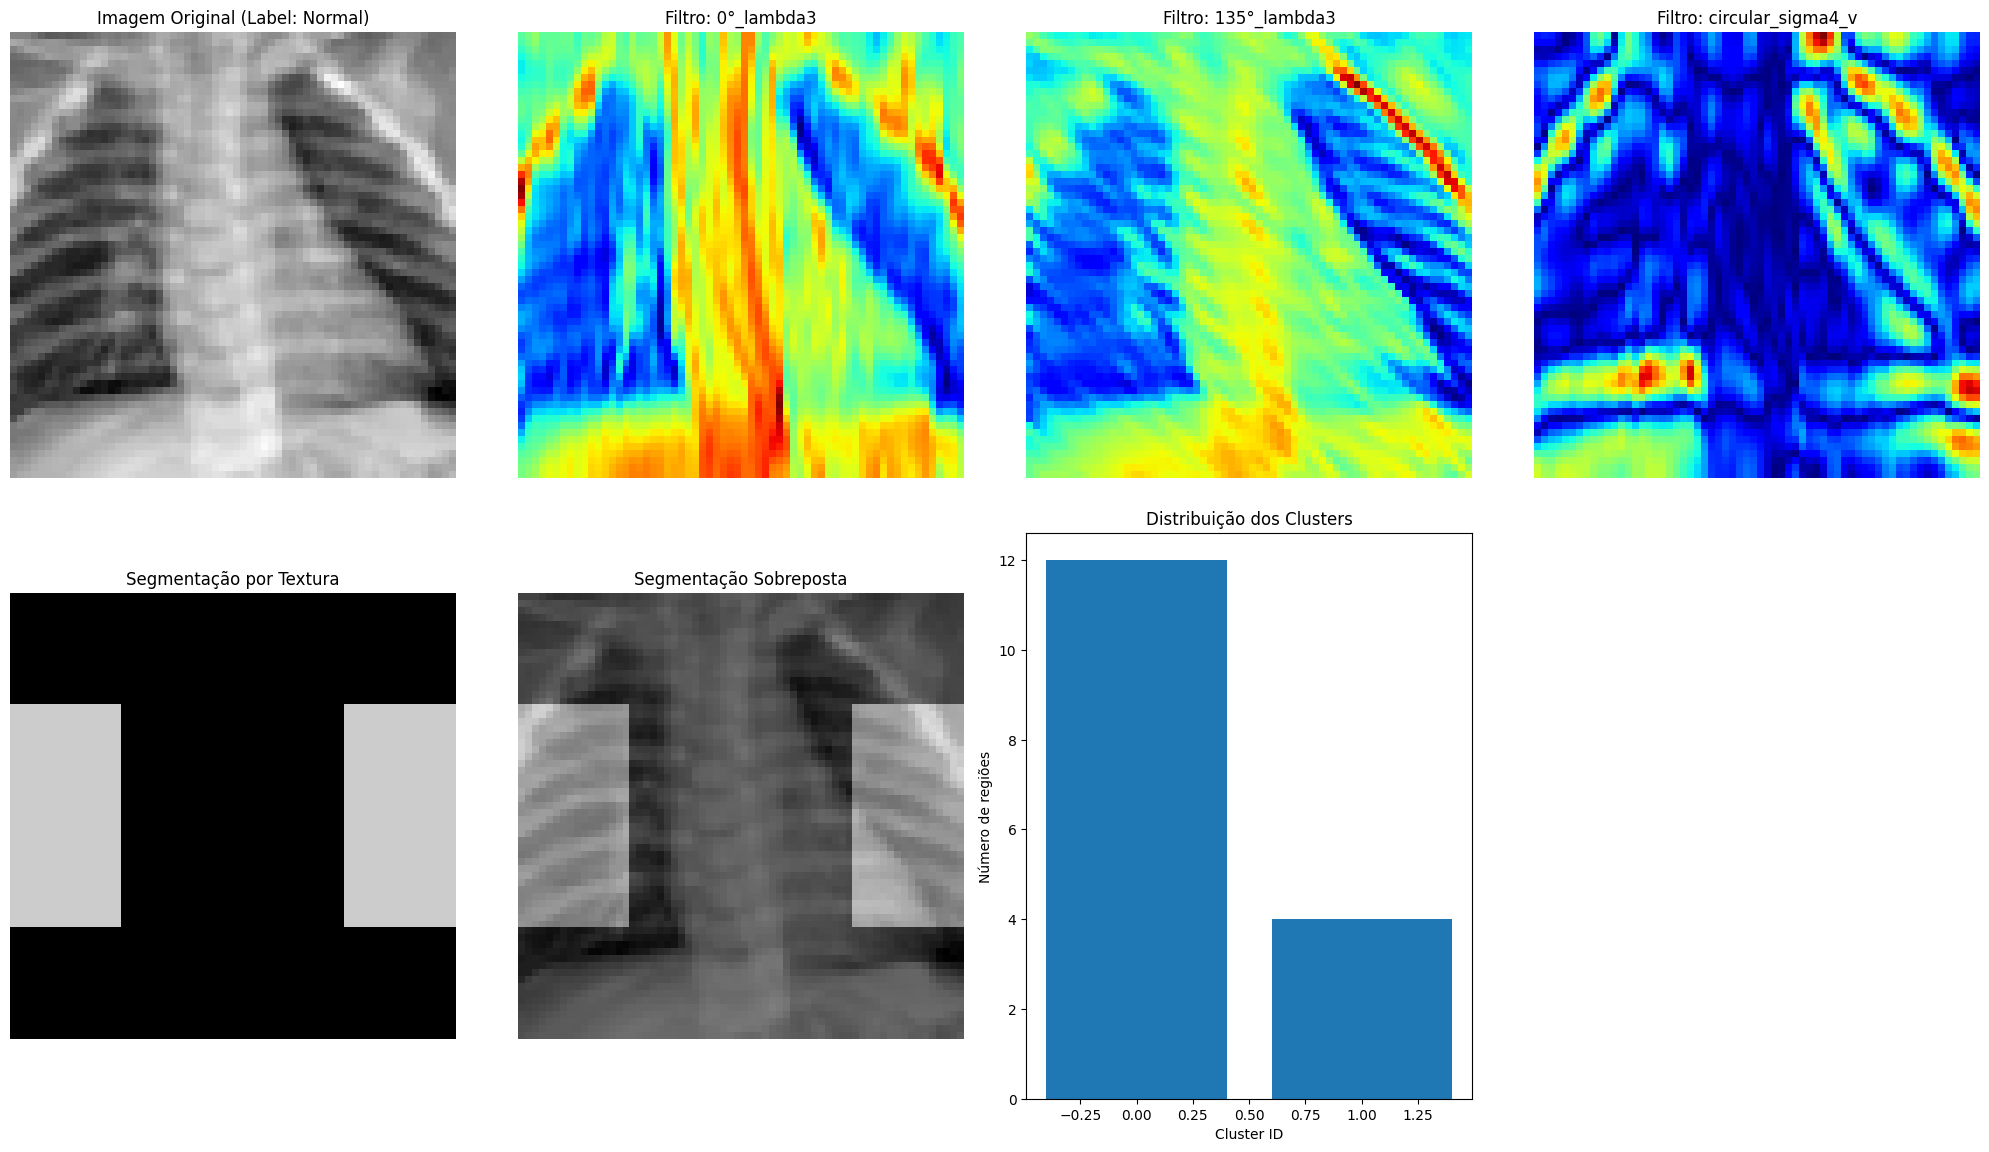


Processando com filtros em múltiplas escalas...


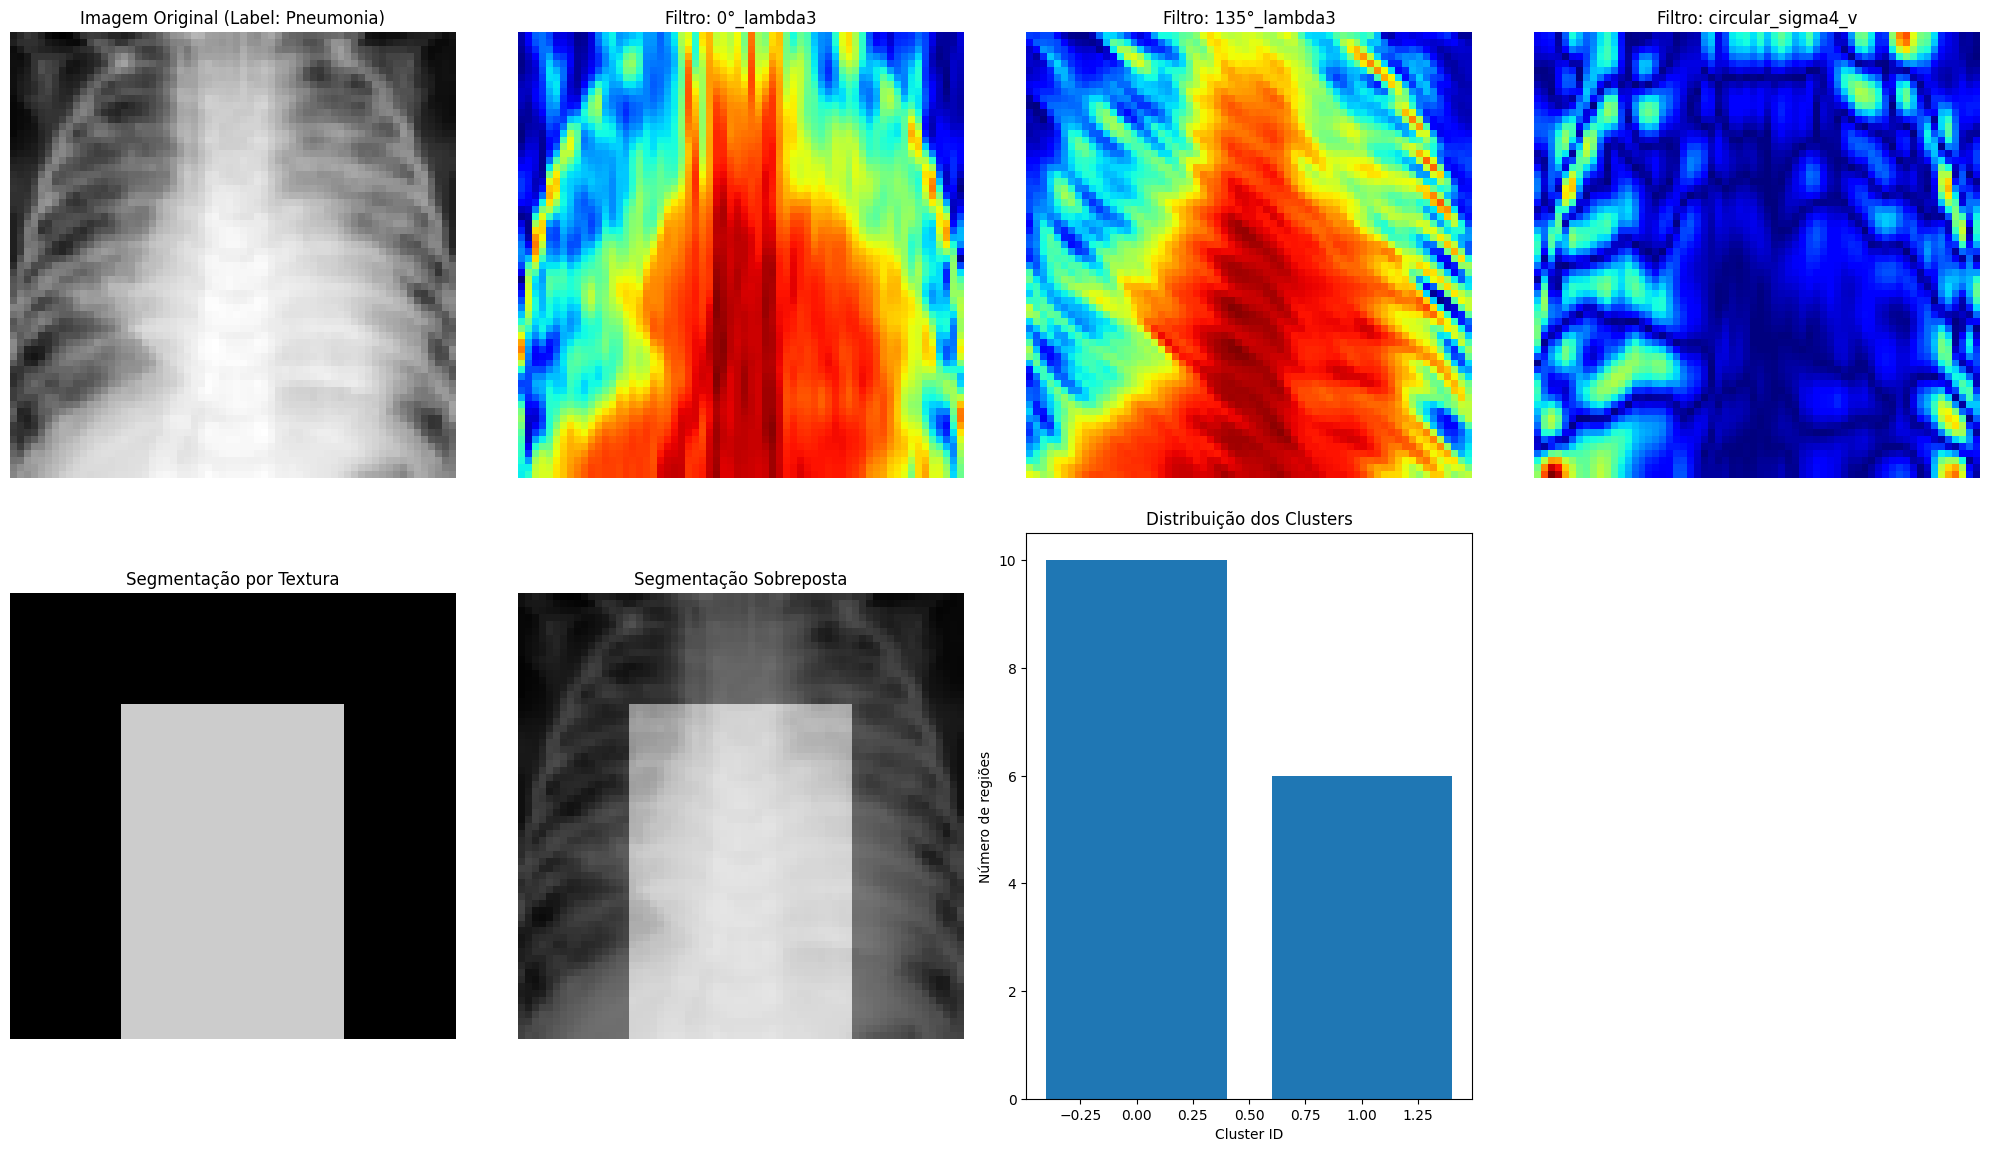


Processando com filtros em múltiplas escalas...


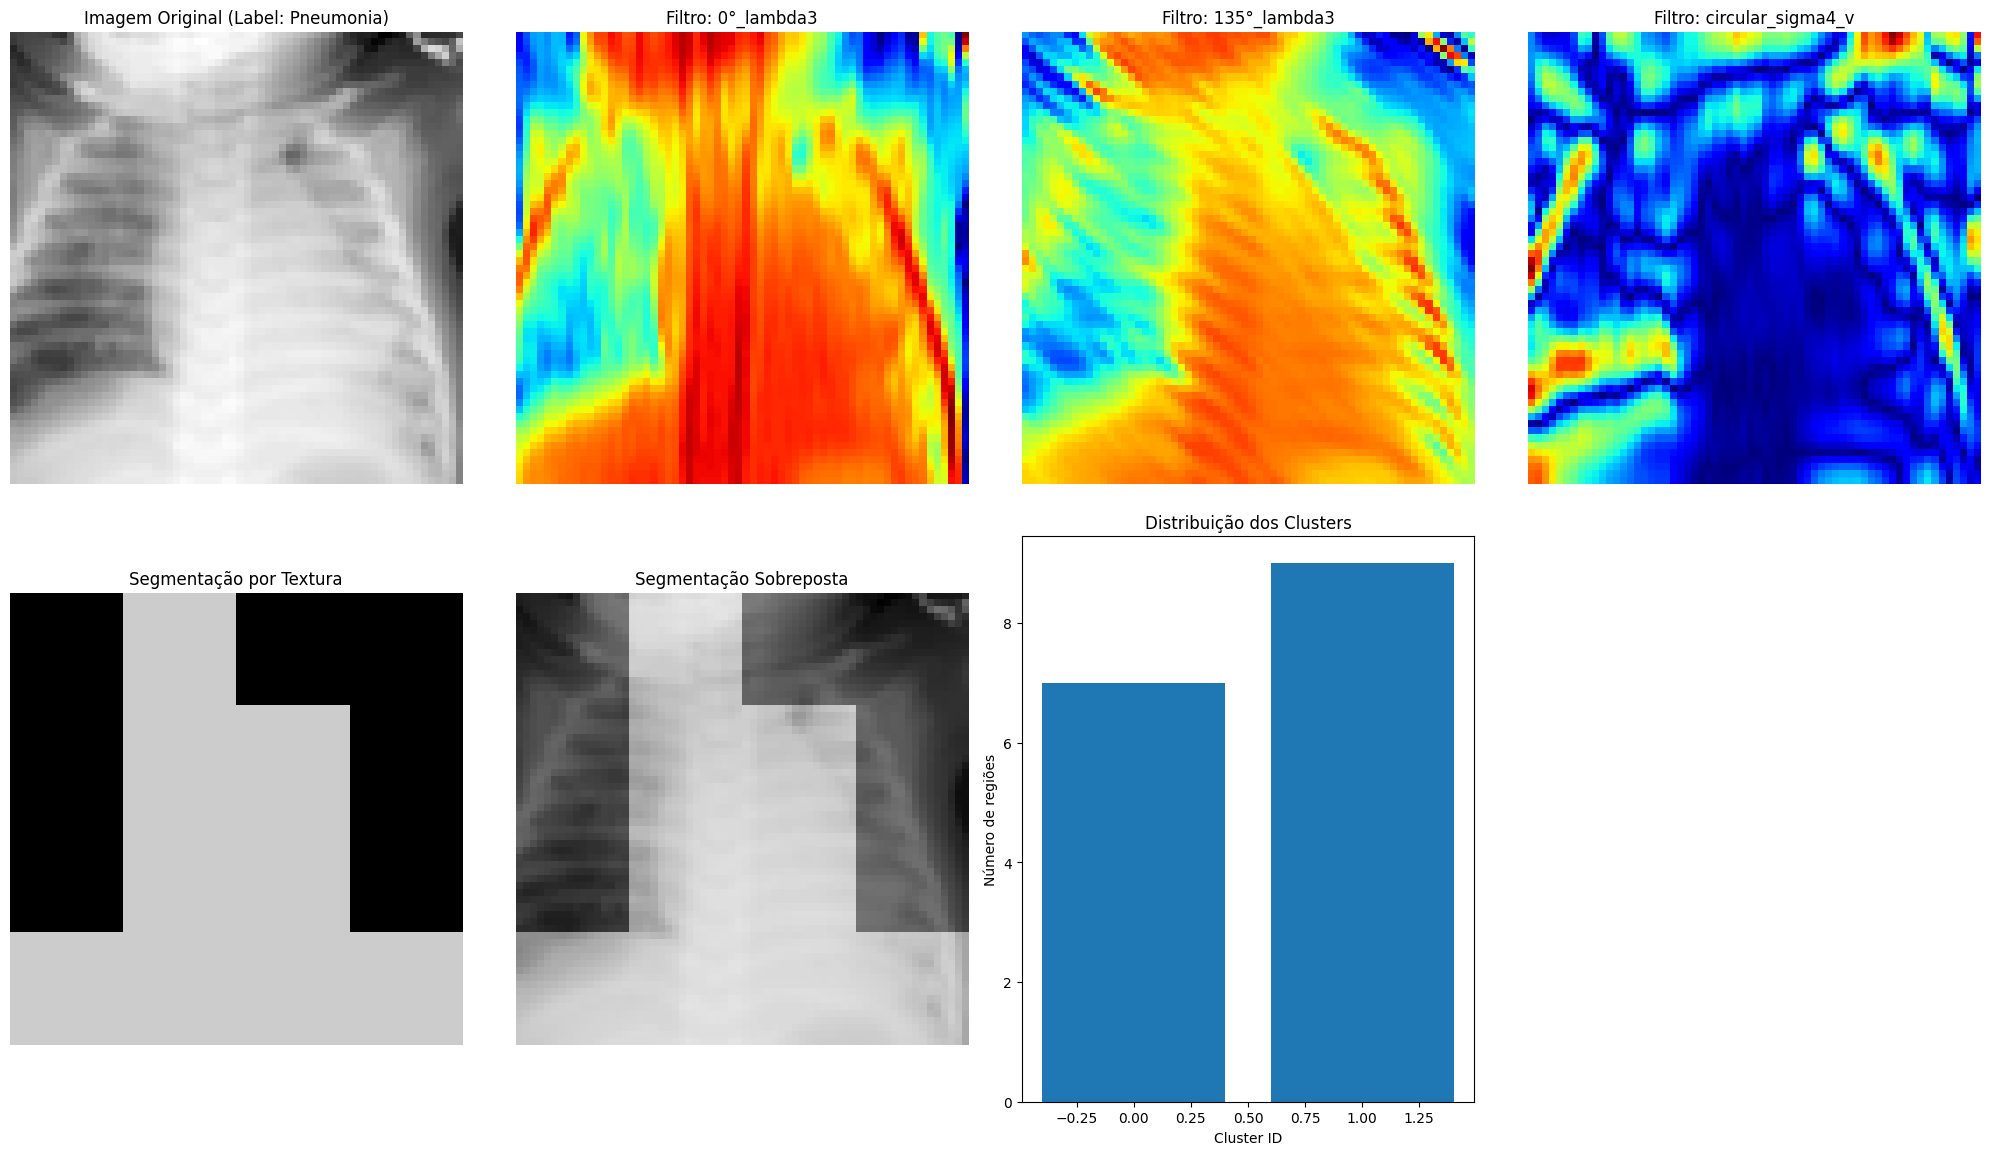


Processando com filtros em múltiplas escalas...


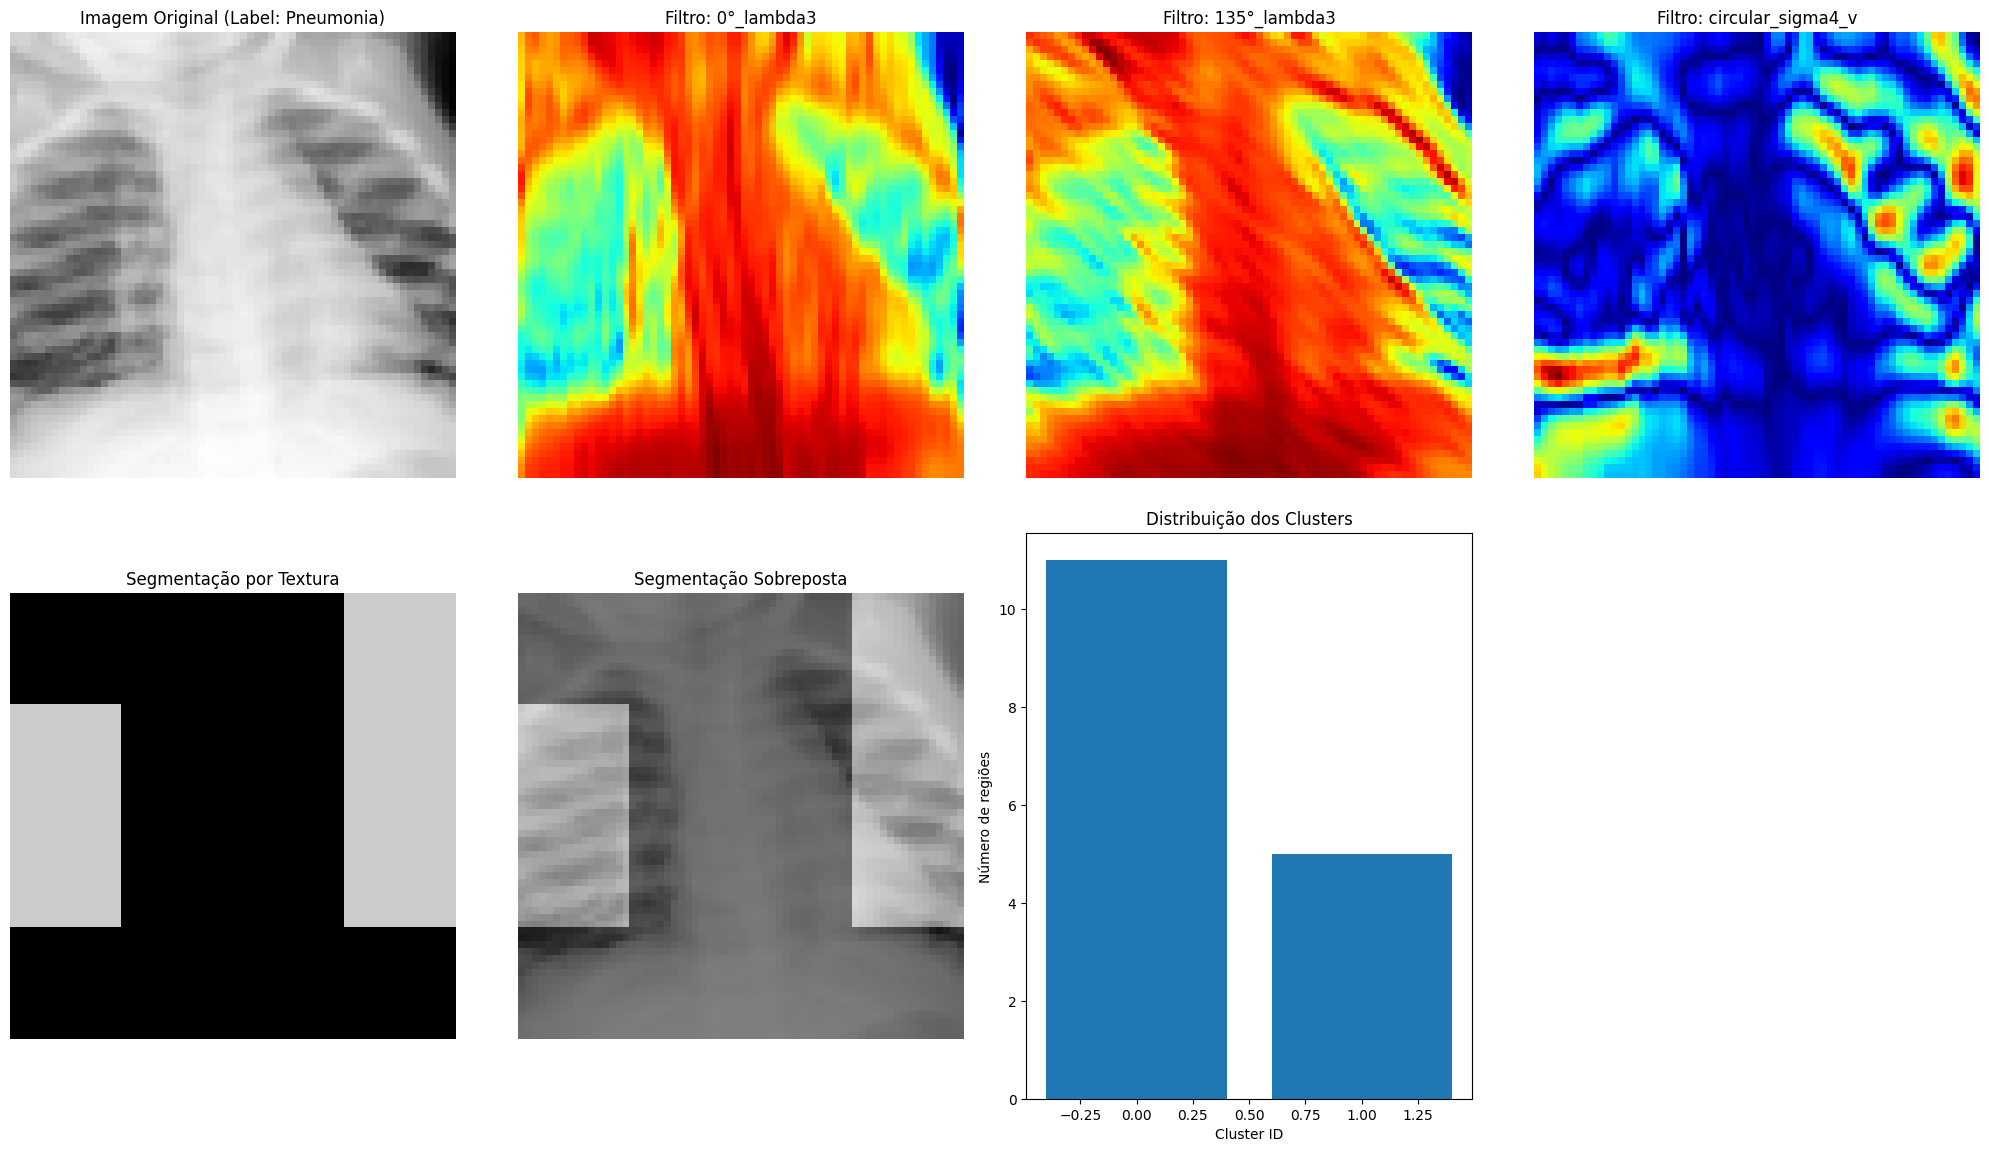


Processando com filtros em múltiplas escalas...


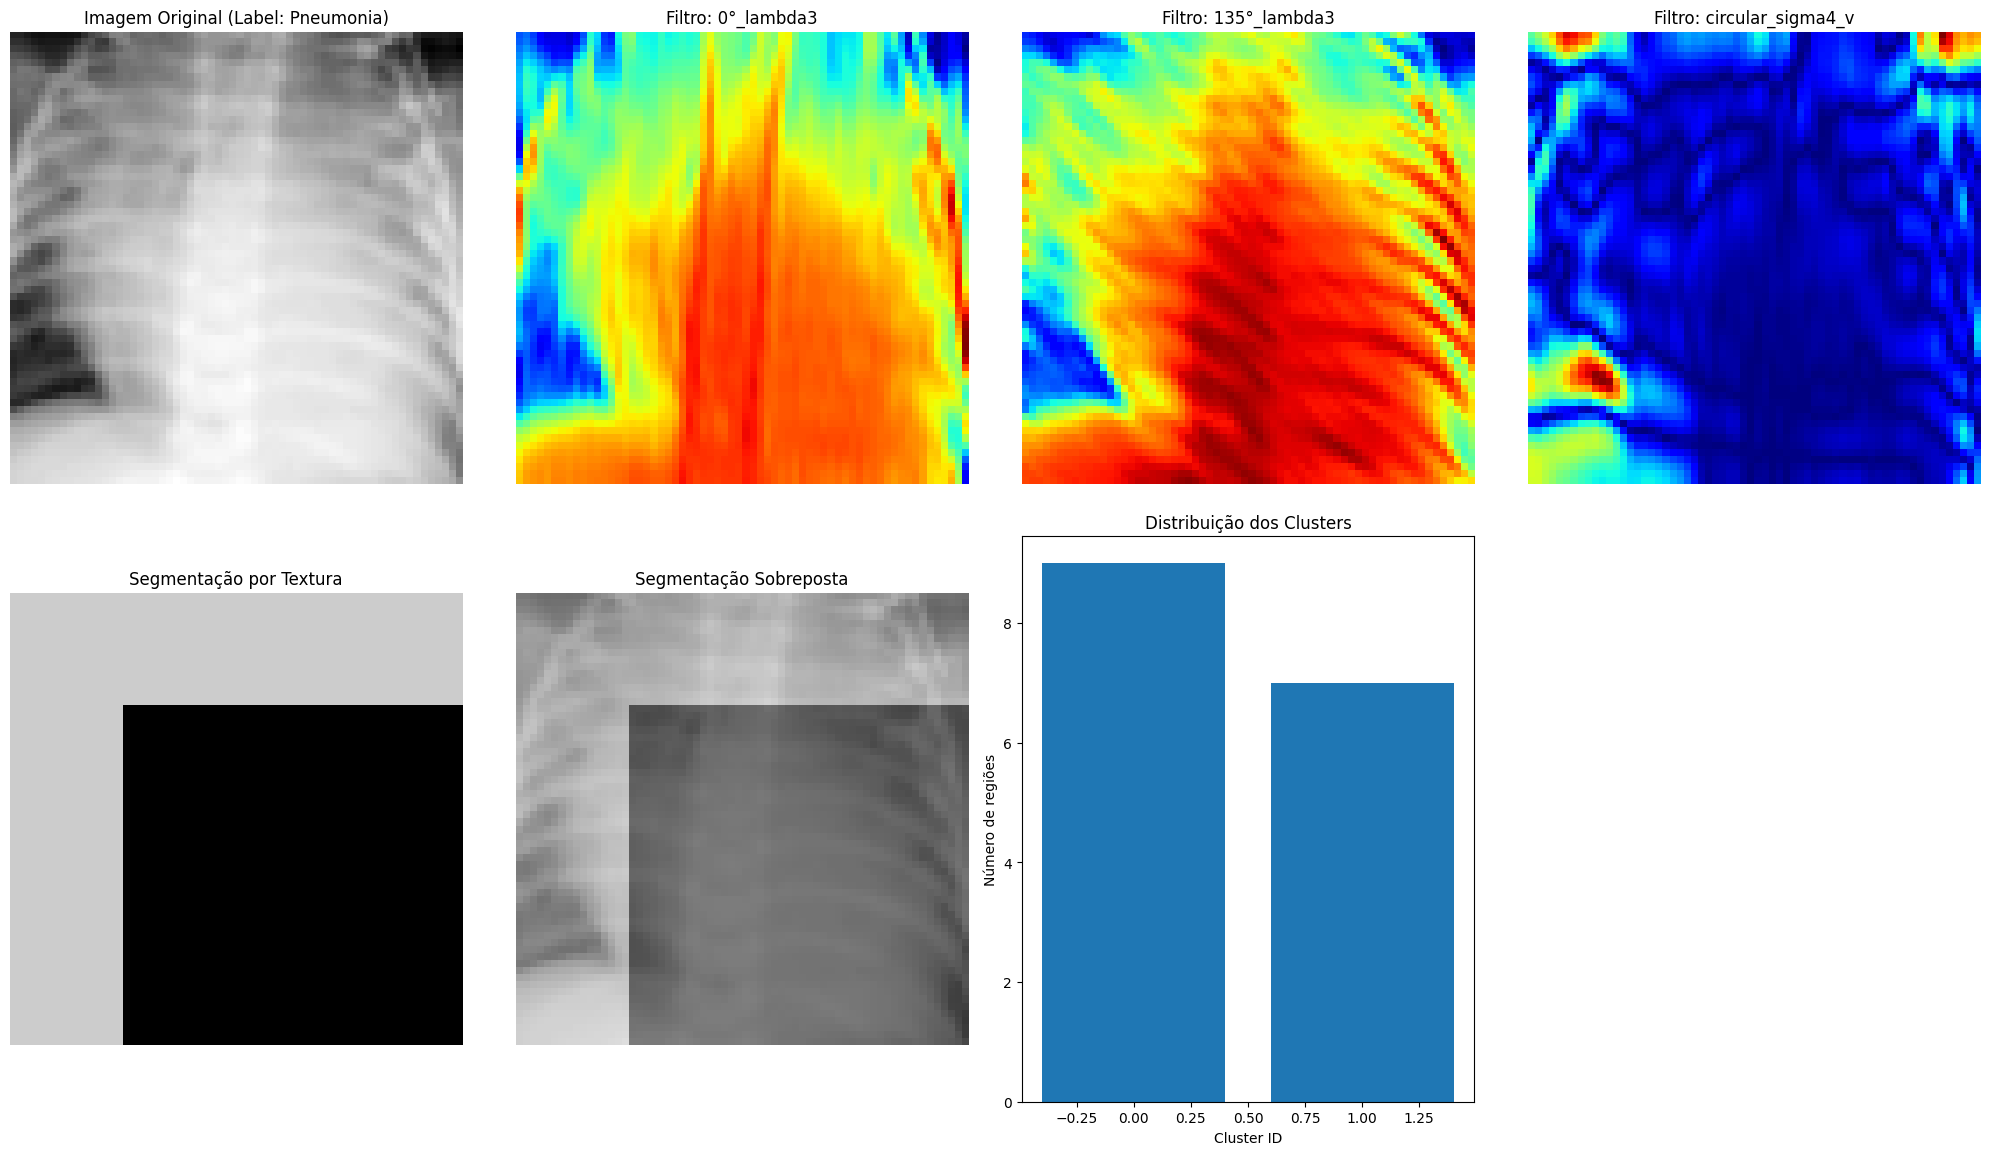


Processando com filtros em múltiplas escalas...


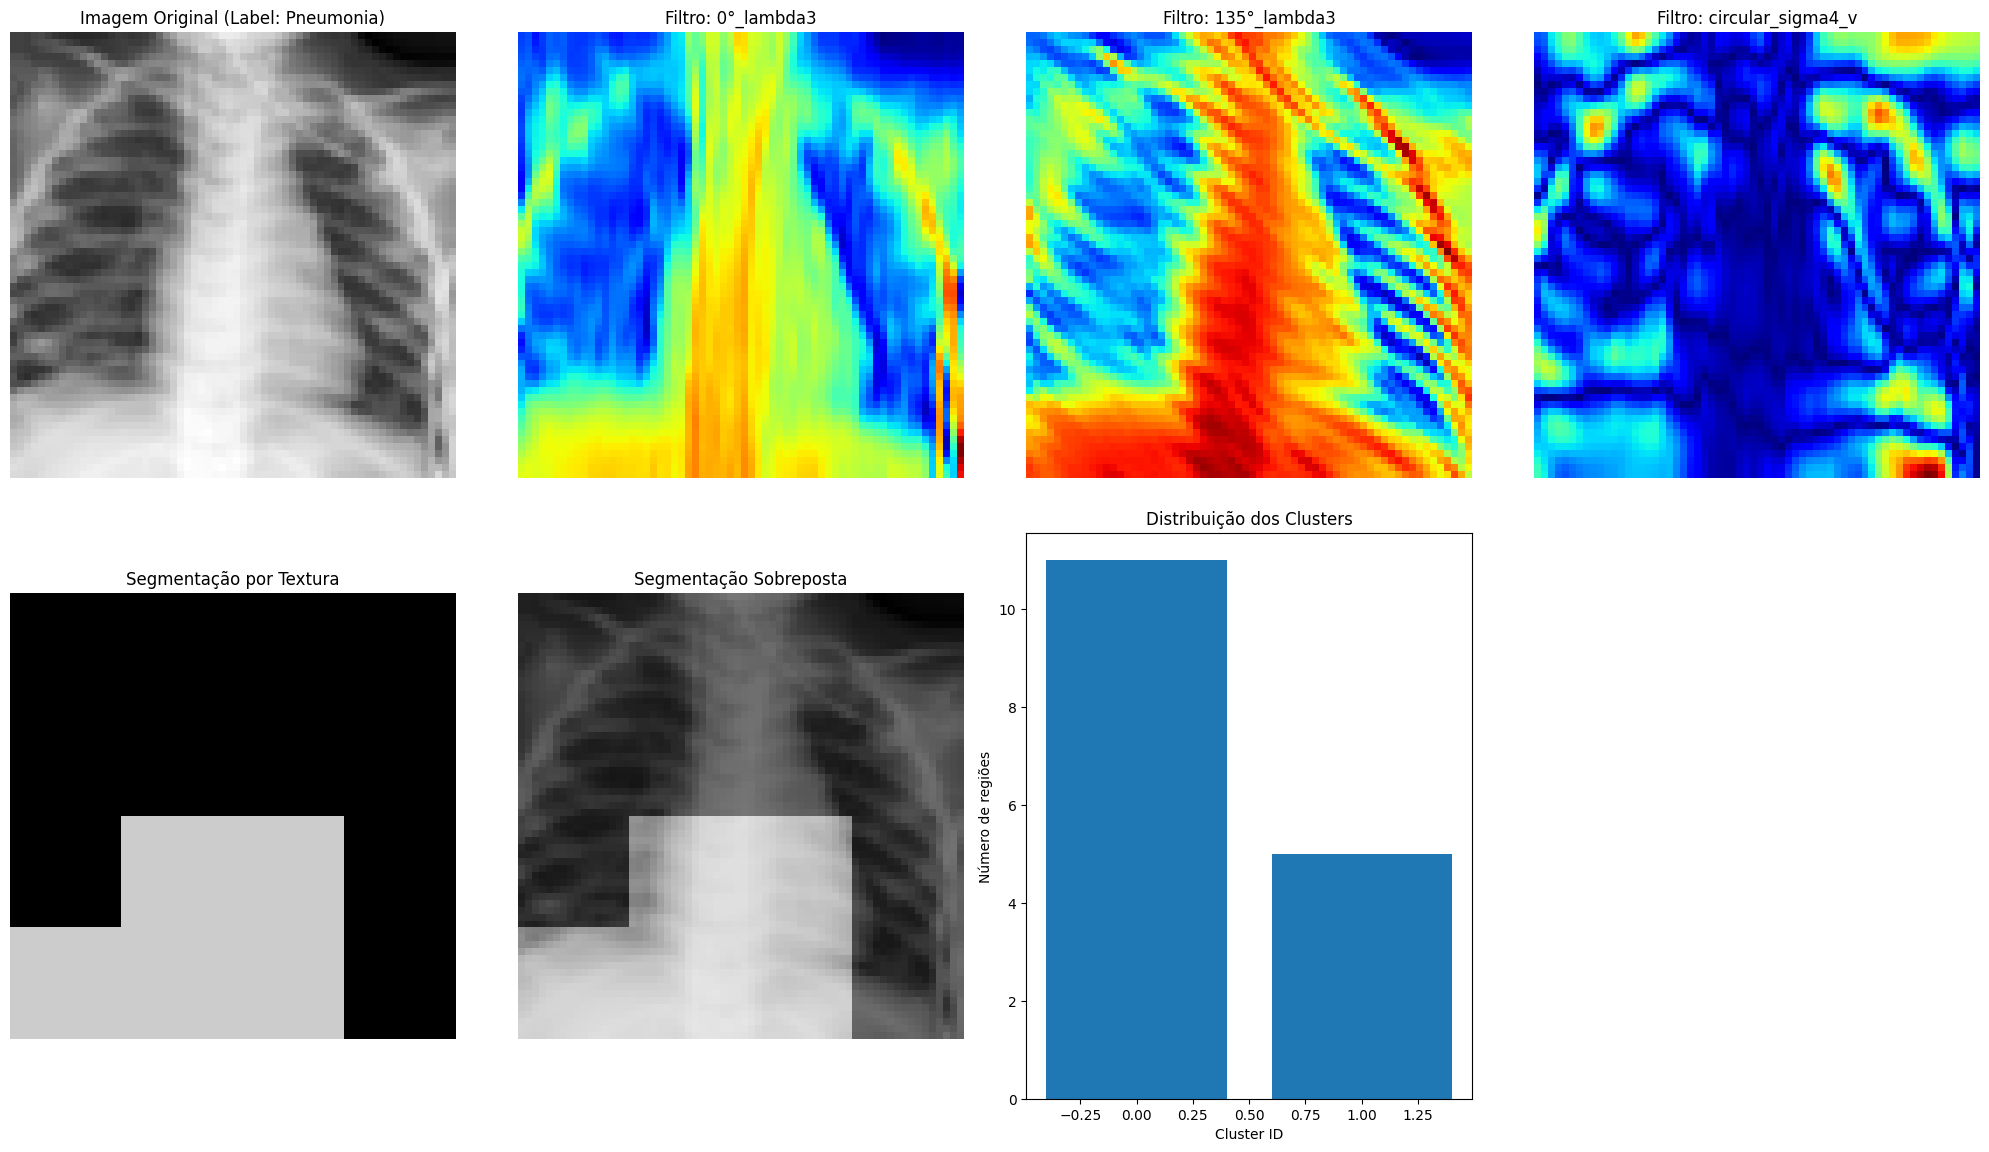


Processando com filtros em múltiplas escalas...


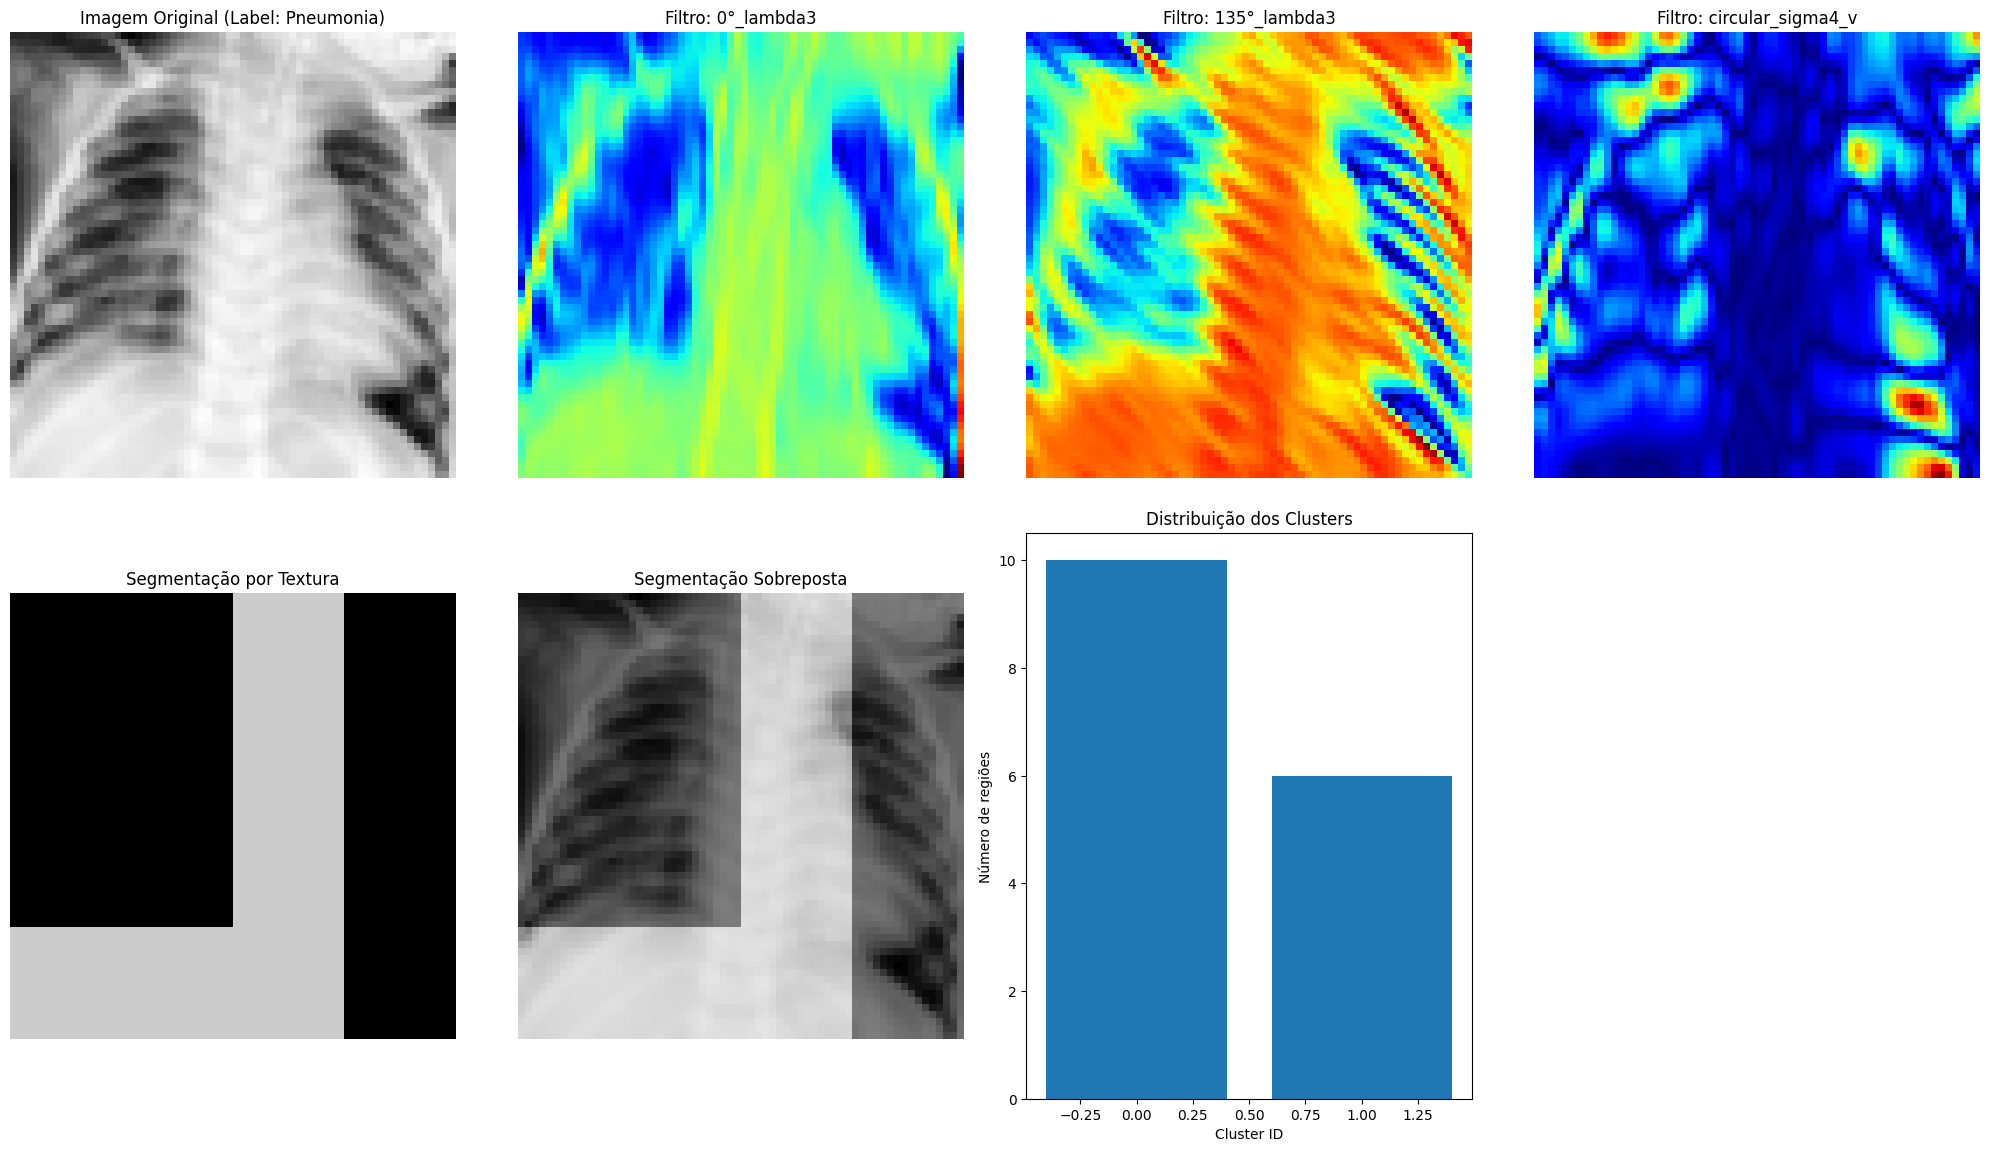

In [ ]:
# Carregar dataset
images, labels = load_dataset(100)

print(f"Dataset carregado. Total de imagens: {len(images)}")
print(f"Distribuição de rótulos: {np.unique(labels, return_counts=True)}")

# Analisar padrões de clusters em relação ao diagnóstico
analyze_cluster_patterns(images, labels)

# Processar a primeira imagem com ambos os métodos
images = images[:16].squeeze()
labels = labels[:16]

for image, label in zip(images, labels):
  # Normalizar a imagem para o intervalo [0, 255]
  image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

  print("\nProcessando com filtros em múltiplas escalas...")
  process_multiscale_filters(image, label)